# Entrainement des modèles

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()


data = pd.read_csv('donneeIngFeaturing.csv', sep='\t')
targetEMI = "logEMI"
targetCONSO = "logCONSO"

## étude avec ENERGY STAR

In [2]:

data = data.drop(columns = ["Unnamed: 0", "Unnamed: 1"])
dataStar = data.dropna()
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [3]:
dataStar.columns
dataStar.shape

(4965, 31)

### Isolation d'un set de données test X_test et y_test

In [4]:
categorical_features = dataStar.columns[16:].to_list()

In [5]:
categorical_features

['UType_Hotel',
 'UType_K-12 School',
 'UType_Multifamily Housing',
 'UType_Non-Refrigerated Warehouse',
 'UType_Office',
 'UType_Other',
 'UType_Parking',
 'UType_Restaurant',
 'UType_Retail Store',
 'BType_Multifamily HR (10+)',
 'BType_Multifamily LR (1-4)',
 'BType_Multifamily MR (5-9)',
 'BType_NonResidential',
 'BType_Nonresidential COS',
 'BType_SPS-District K-12']

In [6]:
from sklearn.model_selection import train_test_split

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'ENERGYSTARScore','logGFAPark', 'logGFABuild']

categorical_features = dataStar.columns[16:].to_list()


X = dataStar[numerical_features + categorical_features]
y = dataStar[[targetEMI] + [targetCONSO]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3972, 22)
(993, 22)
(3972, 2)
(993, 2)


In [7]:
y_trainCONSO = y_train[targetCONSO]
y_trainEMI = y_train[targetEMI]

print(y_trainCONSO.shape)
print(y_trainEMI.shape)

(3972,)
(3972,)


In [8]:
X_train.to_csv('X_train.csv', sep='\t', encoding='utf-8')
y_trainEMI.to_csv('Y_trainEMI.csv', sep='\t', encoding='utf-8')
y_trainCONSO.to_csv('Y_trainCONSO.csv', sep='\t', encoding='utf-8')

X_test.to_csv('X_test.csv', sep='\t', encoding='utf-8')
y_test.to_csv('Y_test.csv', sep='\t', encoding='utf-8')

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


### creation pipeline transformer

In [9]:
X_train.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'ENERGYSTARScore', 'logGFAPark', 'logGFABuild', 'UType_Hotel',
       'UType_K-12 School', 'UType_Multifamily Housing',
       'UType_Non-Refrigerated Warehouse', 'UType_Office', 'UType_Other',
       'UType_Parking', 'UType_Restaurant', 'UType_Retail Store',
       'BType_Multifamily HR (10+)', 'BType_Multifamily LR (1-4)',
       'BType_Multifamily MR (5-9)', 'BType_NonResidential',
       'BType_Nonresidential COS', 'BType_SPS-District K-12'],
      dtype='object')

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [11]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

### Evaluation des modèles avec validation croisées et comparaison avec eds approche de regression naives

#### Initialisation tableau ERROR

In [12]:
ERROR_EMI = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
ERROR_CONSO = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

#### modele linéaire 

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS


model_ML = LinearRegression()


In [14]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'LinearRegression'

##### Emission

In [15]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train , y_train)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]



In [16]:

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [17]:
grid.cv_results_

{'mean_fit_time': array([0.02939267]),
 'std_fit_time': array([0.02157454]),
 'mean_score_time': array([0.00852947]),
 'std_score_time': array([0.00109672]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.94151189]),
 'split1_test_neg_root_mean_squared_error': array([-0.90272085]),
 'split2_test_neg_root_mean_squared_error': array([-0.89923992]),
 'split3_test_neg_root_mean_squared_error': array([-1.00263823]),
 'split4_test_neg_root_mean_squared_error': array([-0.9342722]),
 'mean_test_neg_root_mean_squared_error': array([-0.93607662]),
 'std_test_neg_root_mean_squared_error': array([0.03723653]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.57278502]),
 'split1_test_r2': array([0.63285411]),
 'split2_test_r2': array([0.5983919]),
 'split3_test_r2': array([0.57394134]),
 'split4_test_r2': array([0.57397386]),
 'mean_test_r2': array([0.59038925]),
 'std_test_r2': array([0.02331186]),
 'rank_test_r2': array([1], d

In [18]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [19]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [20]:
ERROR_EMI

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357]]}

##### Consomation

In [21]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train , y_train)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [22]:
grid.cv_results_

{'mean_fit_time': array([0.01317453]),
 'std_fit_time': array([0.00100756]),
 'mean_score_time': array([0.0061614]),
 'std_score_time': array([0.00049076]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.42417906]),
 'split1_test_neg_root_mean_squared_error': array([-0.39601529]),
 'split2_test_neg_root_mean_squared_error': array([-0.39102037]),
 'split3_test_neg_root_mean_squared_error': array([-0.43581043]),
 'split4_test_neg_root_mean_squared_error': array([-0.46782688]),
 'mean_test_neg_root_mean_squared_error': array([-0.42297041]),
 'std_test_neg_root_mean_squared_error': array([0.02802075]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.86465226]),
 'split1_test_r2': array([0.88583193]),
 'split2_test_r2': array([0.87937484]),
 'split3_test_r2': array([0.86421485]),
 'split4_test_r2': array([0.83173318]),
 'mean_test_r2': array([0.86516141]),
 'std_test_r2': array([0.01869703]),
 'rank_test_r2': array([1], 

In [23]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [24]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [25]:
ERROR_CONSO

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777]]}

#### modele linaire avec Elastic Net

In [26]:
from sklearn.linear_model import ElasticNet

model_ML = ElasticNet()


In [27]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'ElasticNet'

In [28]:
model = make_pipeline(preprocessor,model_ML)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [29]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1367.8387202171496, tolerance: 0.6864630929868704
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1396.0226864155607, tolerance: 0.6749675903417093
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1398.6339195699761, tolerance: 0.6916079530076522
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.65857620268162, tolerance: 0.6749675903417093
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.41879937711178, tolerance: 0.6916079530076522
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.16710924718018, tolerance: 0.6641032422707422
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1557.9354133235504, tolerance: 0.6864630929868704
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1573.5504732184024, tolerance: 0.6749675903417093
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1587.031421630388, tolerance: 0.6916079530076522
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [30]:
paramList = list(params.keys())


In [31]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.5904470 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de RMSE est : -0.9360156 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de MAE est : -0.7652966 pour les paramètres alpha 0.0010000 et l1_ratio 0.2500000


In [32]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


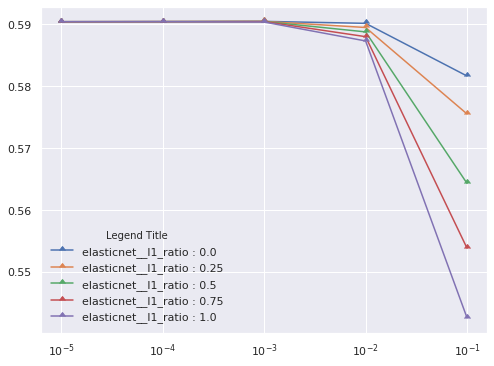

In [33]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


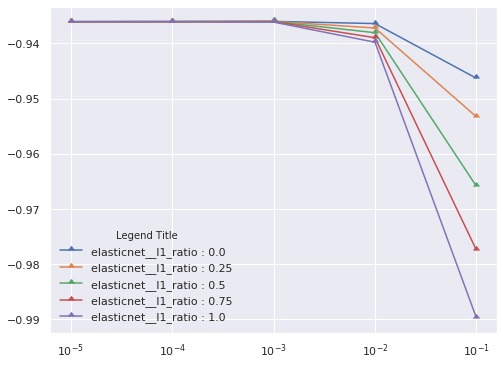

In [34]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


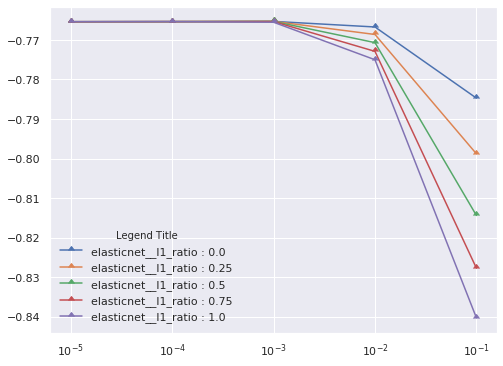

In [35]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [36]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [37]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456]]}

##### Consomation

In [38]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.24852933176675, tolerance: 0.4242357782136054
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.00857763403985, tolerance: 0.4207331715323477
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.85768333139447, tolerance: 0.4292936062121755
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265.52173768130206, tolerance: 0.42660196430914443
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.8409537664581, tolerance: 0.4242357782136054
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.62464480830374, tolerance: 0.4207331715323477
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [39]:
paramList = list(params.keys())


In [40]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.8653156 pour les paramètres alpha 0.0010000 et l1_ratio 1.0000000

Le meilleur score de RMSE est : -0.4227109 pour les paramètres alpha 0.0010000 et l1_ratio 1.0000000

Le meilleur score de MAE est : -0.2676533 pour les paramètres alpha 0.0100000 et l1_ratio 1.0000000


In [41]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


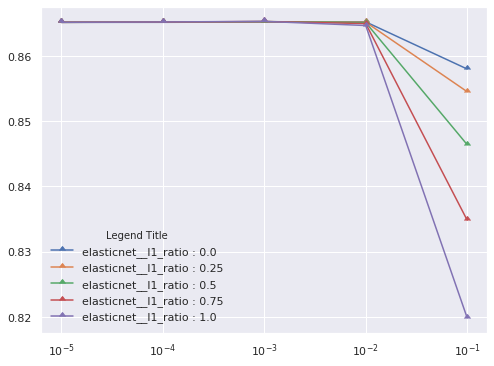

In [42]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


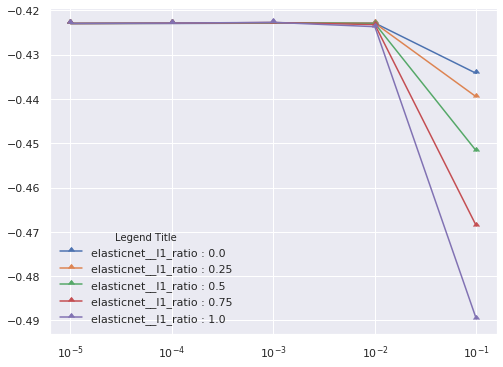

In [43]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


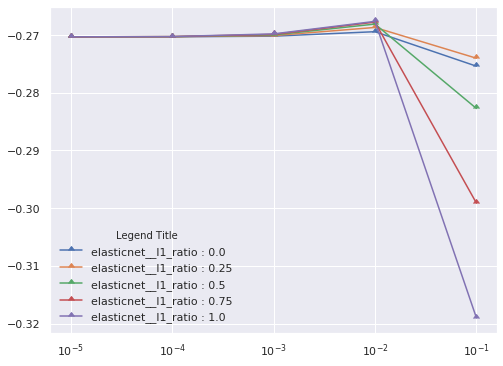

In [44]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [45]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [46]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855]]}

#### modele linaire avec SVR

In [47]:
from sklearn.svm import SVR
model_ML = SVR()

In [48]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0) + "lin"
model_name

'SVRlin'

In [49]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [50]:

params = {
    "svr__C" : np.logspace(-1, 2, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [51]:
grid.cv_results_

{'mean_fit_time': array([1.16057229, 1.20098095, 1.31542988, 2.02541866, 6.26908588]),
 'std_fit_time': array([0.13935602, 0.10631835, 0.09837033, 0.03465755, 0.32060801]),
 'mean_score_time': array([0.1592464 , 0.15802674, 0.1523109 , 0.12949848, 0.13324437]),
 'std_score_time': array([0.02184032, 0.02777838, 0.02413247, 0.00253531, 0.00714157]),
 'param_svr__C': masked_array(data=[0.1, 0.5623413251903491, 3.1622776601683795,
                    17.78279410038923, 100.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.1},
  {'svr__C': 0.5623413251903491},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 17.78279410038923},
  {'svr__C': 100.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.96240864, -0.8920053 , -0.85364639, -0.84774849, -0.85919472]),
 'split1_test_neg_root_mean_squared_error': array([-0.95396509, -0.8651755 , -0.81627436, -0.8204262 , -0.8431038 ]),
 'split2_test_neg_root_mea

In [52]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [53]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6506074 pour les paramètres svr__C : 17.7827941

Le meilleur score de RMSE est : -0.8642159 pour les paramètres svr__C : 17.7827941

Le meilleur score de MAE est : -0.6090227 pour les paramètres svr__C : 17.7827941


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


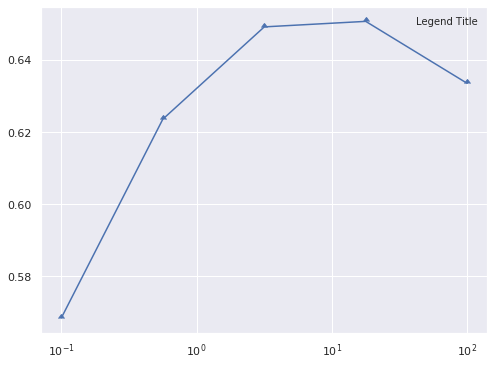

In [54]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


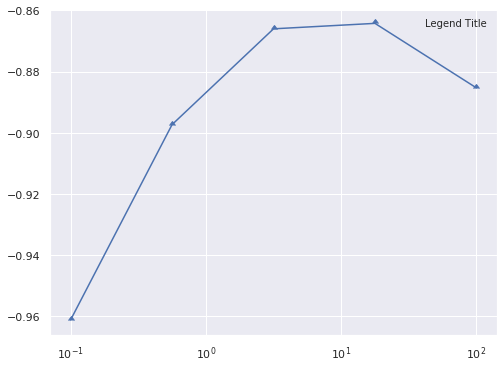

In [55]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


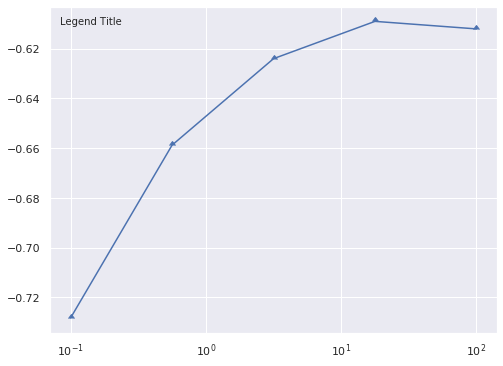

In [56]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [57]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [58]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508]]}

##### Consomation

In [59]:

params = {
    "svr__C" : np.logspace(-2, 3, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [60]:
grid.cv_results_

{'mean_fit_time': array([ 1.03535662,  0.80888014,  1.12247925,  5.56869535, 42.20850511]),
 'std_fit_time': array([0.07785985, 0.0265549 , 0.05411866, 0.39640394, 3.60720942]),
 'mean_score_time': array([0.14455576, 0.10964918, 0.09625621, 0.10019302, 0.06753435]),
 'std_score_time': array([0.00966166, 0.00233885, 0.00152703, 0.01167011, 0.00016948]),
 'param_svr__C': masked_array(data=[0.01, 0.1778279410038923, 3.1622776601683795,
                    56.23413251903491, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.01},
  {'svr__C': 0.1778279410038923},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 56.23413251903491},
  {'svr__C': 1000.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.74763242, -0.47169681, -0.39462482, -0.37730742, -0.44971814]),
 'split1_test_neg_root_mean_squared_error': array([-0.76813533, -0.46748263, -0.35955363, -0.38122487, -0.4294175 ]),
 'split2_test_neg

In [61]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [62]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8912281 pour les paramètres svr__C : 3.1622777

Le meilleur score de RMSE est : -0.3799000 pour les paramètres svr__C : 3.1622777

Le meilleur score de MAE est : -0.2156021 pour les paramètres svr__C : 56.2341325


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


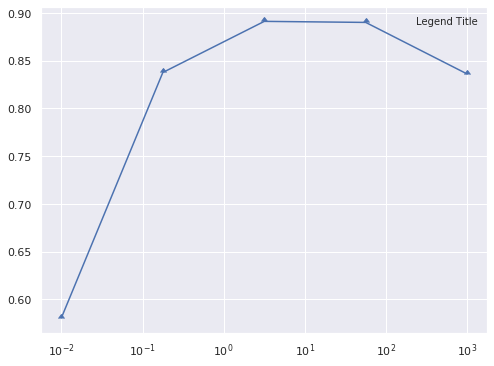

In [63]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


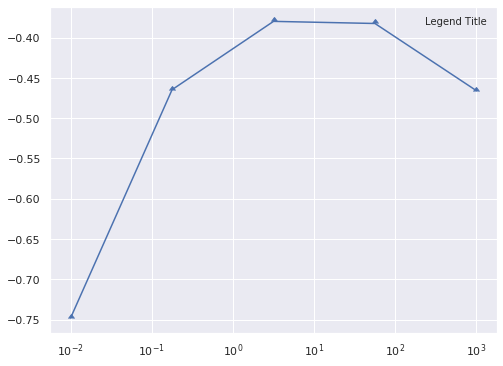

In [64]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


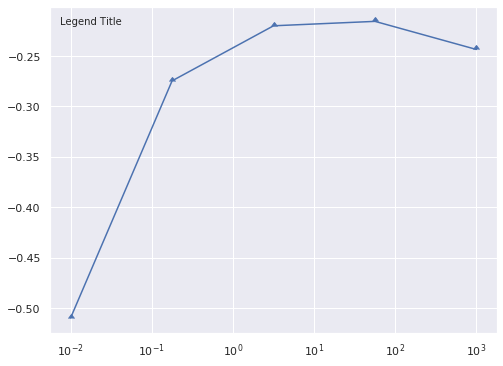

In [65]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [66]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [67]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432]]}

#### modele KNN 

In [68]:
from sklearn.neighbors import KNeighborsRegressor
model_ML = KNeighborsRegressor()

In [69]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KNeighborsRegressor'

In [70]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [71]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,40),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [72]:
grid.cv_results_

{'mean_fit_time': array([0.03903804, 0.03729806, 0.03678408, 0.03778925, 0.0388495 ,
        0.03733826, 0.04340744, 0.03821869, 0.03672419, 0.03701506,
        0.03674974, 0.03710504, 0.03751349, 0.03733926, 0.03712215,
        0.03732004, 0.03678474, 0.03676996, 0.03663135, 0.0370235 ,
        0.03709226, 0.036799  , 0.0371347 , 0.03690343, 0.03686604,
        0.03749294, 0.03629684, 0.03927002, 0.03050556, 0.02856007,
        0.02696877, 0.02659664, 0.02652836, 0.02698684, 0.02686601,
        0.02708354, 0.02698359, 0.02788129, 0.02756853]),
 'std_fit_time': array([0.00377878, 0.00056961, 0.00023872, 0.00126008, 0.00057285,
        0.00088288, 0.00895515, 0.00060027, 0.00017857, 0.00049483,
        0.00016842, 0.00036738, 0.00025904, 0.00052978, 0.00049463,
        0.00056975, 0.00022585, 0.00027324, 0.00022494, 0.00059759,
        0.00036117, 0.00014796, 0.00043431, 0.000265  , 0.00039562,
        0.0005853 , 0.00100021, 0.00379388, 0.00119754, 0.00057708,
        0.00030207, 0.000

In [73]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [74]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5890938 pour les paramètres kneighborsregressor__n_neighbors : 3.0000000

Le meilleur score de RMSE est : -0.9379357 pour les paramètres kneighborsregressor__n_neighbors : 3.0000000

Le meilleur score de MAE est : -0.5558440 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


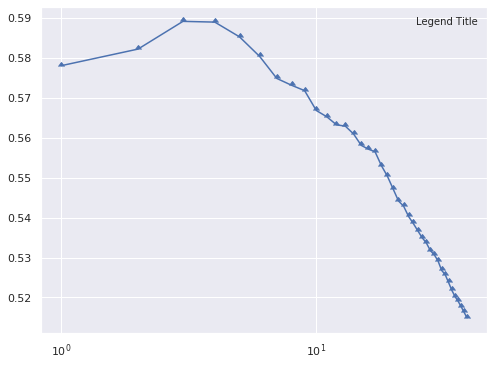

In [75]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


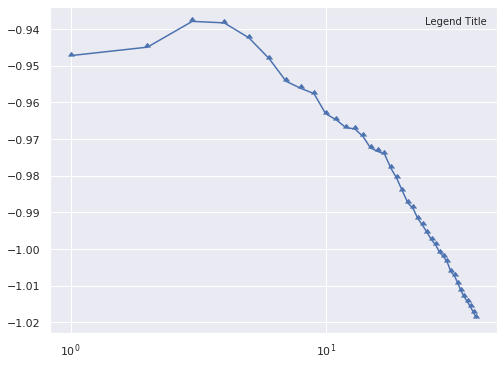

In [76]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


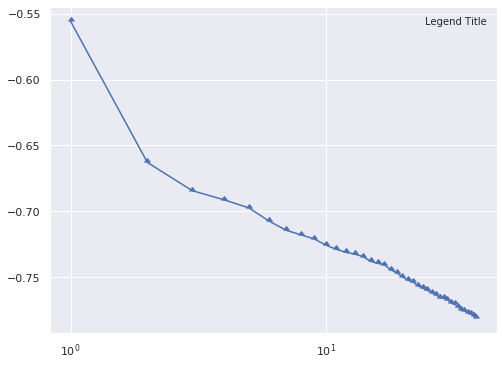

In [77]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [78]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [79]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163]]}

##### Consomation

In [80]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,20),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [81]:
grid.cv_results_

{'mean_fit_time': array([0.03410044, 0.03388333, 0.03370848, 0.03400707, 0.03380852,
        0.03389611, 0.03425593, 0.03463855, 0.03783231, 0.03666277,
        0.0379693 , 0.0362237 , 0.0342515 , 0.03813605, 0.03432913,
        0.03409171, 0.03414726, 0.03428926, 0.03437762]),
 'std_fit_time': array([2.29188872e-04, 1.95239575e-04, 1.75450779e-04, 2.36455224e-04,
        2.22816897e-04, 8.23178392e-05, 8.04454775e-04, 7.80616080e-04,
        4.31691622e-03, 7.22261316e-04, 1.57588091e-03, 1.63582408e-03,
        8.87654795e-04, 1.03804827e-03, 5.36004533e-04, 2.62324325e-04,
        1.53560149e-04, 1.15547453e-04, 3.39885546e-04]),
 'mean_score_time': array([0.11203327, 0.11479902, 0.1163682 , 0.11762853, 0.1187408 ,
        0.11974821, 0.1228756 , 0.12334018, 0.13143673, 0.1336525 ,
        0.13565698, 0.13091412, 0.12641559, 0.13979101, 0.12711835,
        0.12638507, 0.12668657, 0.12737398, 0.12807446]),
 'std_score_time': array([0.00066592, 0.0009158 , 0.00094678, 0.00063434, 0.00

In [82]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [83]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8073276 pour les paramètres kneighborsregressor__n_neighbors : 2.0000000

Le meilleur score de RMSE est : -0.5066616 pour les paramètres kneighborsregressor__n_neighbors : 2.0000000

Le meilleur score de MAE est : -0.2797494 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


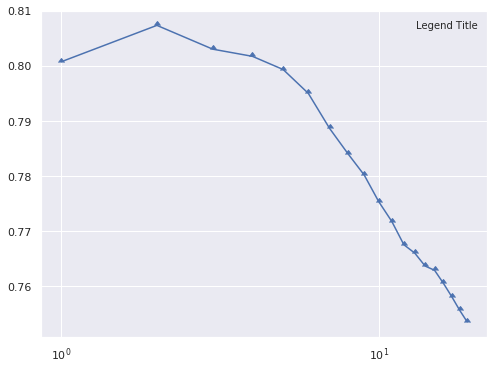

In [84]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


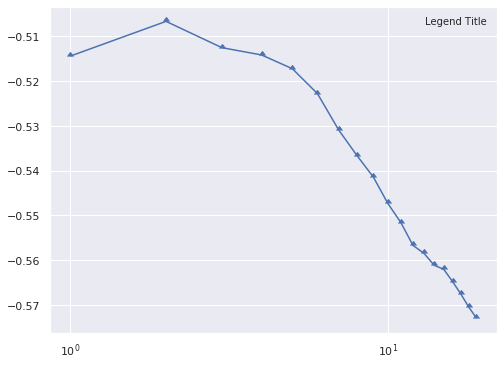

In [85]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


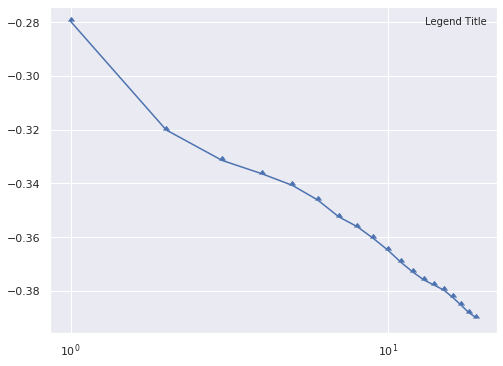

In [86]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [87]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [88]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876]]}

In [89]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876]]}

#### modele non linéaire La régression ridge à noyau

In [90]:
from sklearn import kernel_ridge
model_ML = kernel_ridge.KernelRidge()
       

In [91]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KernelRidge'

In [92]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [93]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [94]:
grid.cv_results_

{'mean_fit_time': array([0.63081241, 0.63773766, 0.63095579, 0.63064466, 0.6303421 ,
        0.62664866, 0.63314619, 0.62799954, 0.62465701, 0.62890673,
        0.62994514, 0.62337999, 0.62397208, 0.62452369, 0.62511592,
        0.57297382, 0.50006375, 0.49882345, 0.50194874, 0.50475802,
        0.50446172, 0.49843225, 0.50367374, 0.50109358, 0.50213995]),
 'std_fit_time': array([0.02723352, 0.00568999, 0.00412956, 0.00398187, 0.00256761,
        0.0043908 , 0.01235073, 0.00387668, 0.00270981, 0.00344979,
        0.00241526, 0.00285958, 0.00332531, 0.00608416, 0.00296775,
        0.07156721, 0.00543212, 0.00168827, 0.00598547, 0.00525048,
        0.00444792, 0.00228115, 0.00460262, 0.00444246, 0.00381883]),
 'mean_score_time': array([0.04741383, 0.04637413, 0.04672332, 0.04630408, 0.04633222,
        0.04624343, 0.04665475, 0.04848714, 0.047051  , 0.04660196,
        0.04668427, 0.04636955, 0.04612842, 0.04621992, 0.04623542,
        0.04190316, 0.03884377, 0.03906236, 0.03891258, 0.03

In [95]:
grid.cv_results_

{'mean_fit_time': array([0.63081241, 0.63773766, 0.63095579, 0.63064466, 0.6303421 ,
        0.62664866, 0.63314619, 0.62799954, 0.62465701, 0.62890673,
        0.62994514, 0.62337999, 0.62397208, 0.62452369, 0.62511592,
        0.57297382, 0.50006375, 0.49882345, 0.50194874, 0.50475802,
        0.50446172, 0.49843225, 0.50367374, 0.50109358, 0.50213995]),
 'std_fit_time': array([0.02723352, 0.00568999, 0.00412956, 0.00398187, 0.00256761,
        0.0043908 , 0.01235073, 0.00387668, 0.00270981, 0.00344979,
        0.00241526, 0.00285958, 0.00332531, 0.00608416, 0.00296775,
        0.07156721, 0.00543212, 0.00168827, 0.00598547, 0.00525048,
        0.00444792, 0.00228115, 0.00460262, 0.00444246, 0.00381883]),
 'mean_score_time': array([0.04741383, 0.04637413, 0.04672332, 0.04630408, 0.04633222,
        0.04624343, 0.04665475, 0.04848714, 0.047051  , 0.04660196,
        0.04668427, 0.04636955, 0.04612842, 0.04621992, 0.04623542,
        0.04190316, 0.03884377, 0.03906236, 0.03891258, 0.03

In [96]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [97]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6534066 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de RMSE est : -0.8610243 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de MAE est : -0.6432367 pour les paramètres kernelridge__alpha : 0.0031623 et kernelridge__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


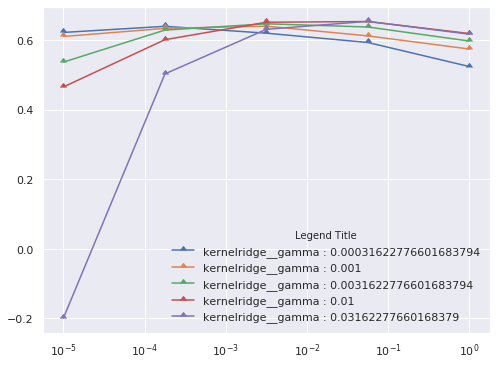

In [98]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


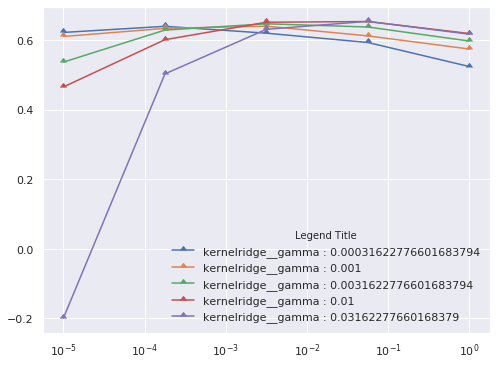

In [99]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


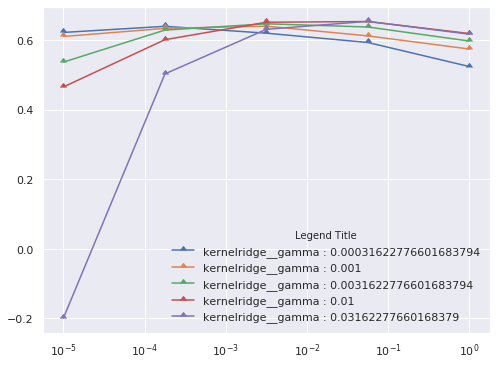

In [100]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [101]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [102]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663]]}

##### Consomation 

In [103]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [104]:
grid.cv_results_

{'mean_fit_time': array([0.5325417 , 0.57759943, 0.57799401, 0.58046498, 0.60558143,
        0.58020349, 0.57163148, 0.57151217, 0.57319589, 0.57175555,
        0.56965861, 0.57325168, 0.57295575, 0.55704765, 0.50089951,
        0.49948111, 0.49938564, 0.49998546, 0.5010006 , 0.49909091,
        0.49715037, 0.49980631, 0.50361524, 0.49936404, 0.5015233 ]),
 'std_fit_time': array([0.02999657, 0.0013341 , 0.0041984 , 0.0046031 , 0.04220694,
        0.01174808, 0.00323373, 0.00421344, 0.00424804, 0.00269443,
        0.00518852, 0.00674454, 0.0058167 , 0.03012294, 0.00595279,
        0.00400302, 0.00290307, 0.00594859, 0.00331693, 0.00377601,
        0.00297127, 0.00241136, 0.0072784 , 0.00281527, 0.00238712]),
 'mean_score_time': array([0.04293404, 0.04498286, 0.04478841, 0.04521737, 0.05017157,
        0.04503741, 0.04437556, 0.04438791, 0.04465346, 0.04427543,
        0.04436851, 0.0443222 , 0.04446659, 0.04281502, 0.03879614,
        0.03886557, 0.03891258, 0.03870525, 0.0387116 , 0.03

In [105]:
grid.cv_results_

{'mean_fit_time': array([0.5325417 , 0.57759943, 0.57799401, 0.58046498, 0.60558143,
        0.58020349, 0.57163148, 0.57151217, 0.57319589, 0.57175555,
        0.56965861, 0.57325168, 0.57295575, 0.55704765, 0.50089951,
        0.49948111, 0.49938564, 0.49998546, 0.5010006 , 0.49909091,
        0.49715037, 0.49980631, 0.50361524, 0.49936404, 0.5015233 ]),
 'std_fit_time': array([0.02999657, 0.0013341 , 0.0041984 , 0.0046031 , 0.04220694,
        0.01174808, 0.00323373, 0.00421344, 0.00424804, 0.00269443,
        0.00518852, 0.00674454, 0.0058167 , 0.03012294, 0.00595279,
        0.00400302, 0.00290307, 0.00594859, 0.00331693, 0.00377601,
        0.00297127, 0.00241136, 0.0072784 , 0.00281527, 0.00238712]),
 'mean_score_time': array([0.04293404, 0.04498286, 0.04478841, 0.04521737, 0.05017157,
        0.04503741, 0.04437556, 0.04438791, 0.04465346, 0.04427543,
        0.04436851, 0.0443222 , 0.04446659, 0.04281502, 0.03879614,
        0.03886557, 0.03891258, 0.03870525, 0.0387116 , 0.03

In [106]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [107]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8984643 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de RMSE est : -0.3669700 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de MAE est : -0.2205451 pour les paramètres kernelridge__alpha : 0.0001778 et kernelridge__gamma : 0.0031623


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


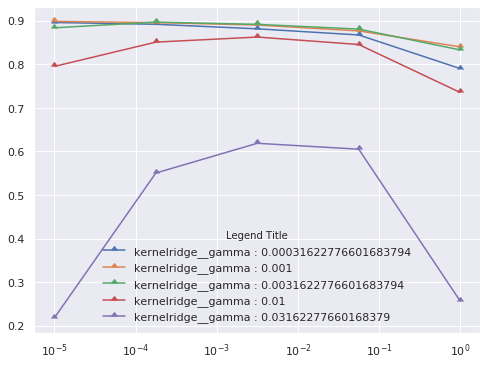

In [108]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


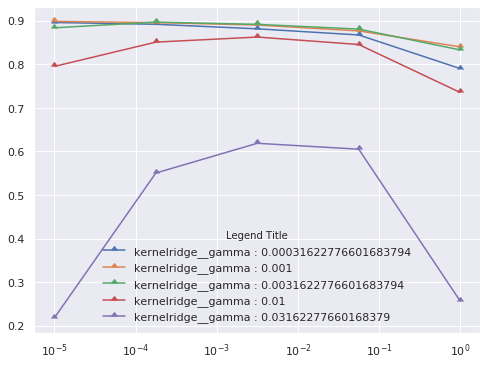

In [109]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


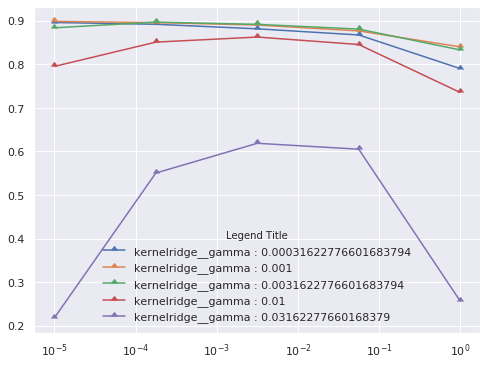

In [110]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [111]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [112]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876],
  [0.8984642754998406, -0.3669699764144684, -0.22054511868325383]]}

#### modele non linéaire : SVR

In [113]:
from sklearn.svm import SVR
model_ML = SVR()
                                     


In [114]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'SVR'

In [115]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [116]:



params = {
    "svr__C" : np.logspace(-1, 2, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 3)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [117]:
grid.cv_results_

{'mean_fit_time': array([1.07370081, 1.05881009, 1.08800502, 1.10868535, 0.77693319,
        0.81835222, 0.85366192, 0.81925635, 0.84828606, 0.79505811,
        0.88894029, 1.32290015, 0.86574869, 1.31847596, 3.60313387]),
 'std_fit_time': array([0.0381174 , 0.01503119, 0.05304227, 0.09189935, 0.01042003,
        0.01781514, 0.05020054, 0.02921737, 0.00904722, 0.00514069,
        0.00964197, 0.03698271, 0.01175156, 0.02168342, 0.29002338]),
 'mean_score_time': array([0.15195518, 0.16389298, 0.15331798, 0.15654116, 0.10873299,
        0.10846219, 0.12050347, 0.10731874, 0.09950576, 0.1067503 ,
        0.10422959, 0.0974287 , 0.10580816, 0.10145564, 0.09428611]),
 'std_score_time': array([0.00525179, 0.01749713, 0.00989264, 0.0209905 , 0.00118261,
        0.00176568, 0.00616738, 0.00343865, 0.00054749, 0.00209435,
        0.00093515, 0.00111475, 0.00082037, 0.00056578, 0.00179165]),
 'param_svr__C': masked_array(data=[0.1, 0.1, 0.1, 0.5623413251903491, 0.5623413251903491,
               

In [118]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [119]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6484941 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de RMSE est : -0.8667941 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de MAE est : -0.6166073 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


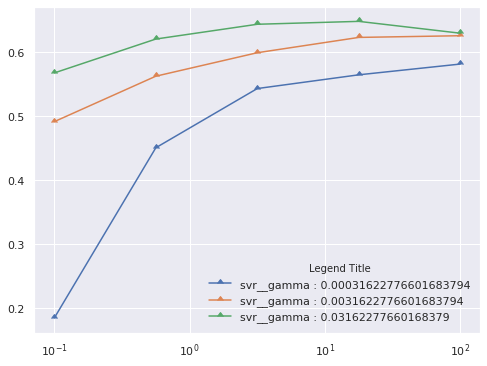

In [120]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


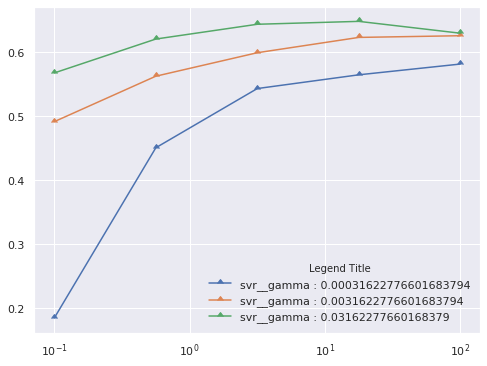

In [121]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


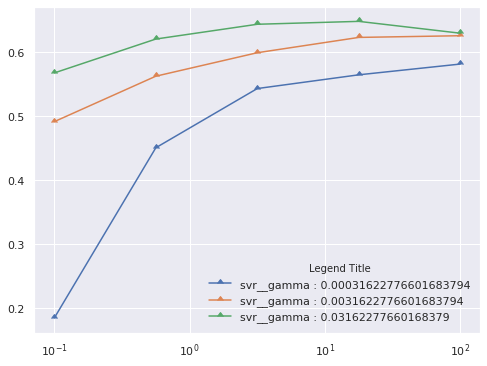

In [122]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [123]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [124]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584]]}

##### Consomation

In [125]:



params = {
    "svr__C" : np.logspace(-2, 3, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 5)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [126]:
grid.cv_results_

{'mean_fit_time': array([ 1.10320854,  1.08978219,  0.91901283,  0.71030111,  0.67173314,
         0.7288003 ,  0.70674253,  0.56204214,  0.52963138,  0.53396845,
         0.55352545,  0.55513616,  0.59067254,  0.640625  ,  0.73753953,
         0.6558991 ,  0.84145947,  1.15484619,  1.99872599,  3.34499655,
         1.80269828,  4.58337712,  8.02500267, 21.55387349, 38.96469131]),
 'std_fit_time': array([0.04574003, 0.03181349, 0.10514932, 0.00427697, 0.00939385,
        0.00500073, 0.02263108, 0.01119065, 0.00516959, 0.00574837,
        0.0048843 , 0.00885935, 0.01340381, 0.01334574, 0.01678135,
        0.01247735, 0.0276073 , 0.04232963, 0.10803491, 0.1902813 ,
        0.07772581, 0.40764068, 0.66138359, 1.98708624, 2.14352832]),
 'mean_score_time': array([0.15992022, 0.14921646, 0.12624464, 0.10271482, 0.09901824,
        0.10528831, 0.09864006, 0.0796319 , 0.07668071, 0.07697501,
        0.07777824, 0.07694664, 0.07423038, 0.07159429, 0.06934419,
        0.0745841 , 0.07507505, 0.0

In [127]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [128]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8963949 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0100000

Le meilleur score de RMSE est : -0.3699355 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0100000

Le meilleur score de MAE est : -0.2136538 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0100000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


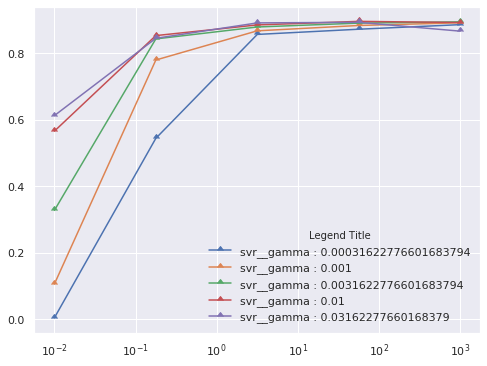

In [129]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


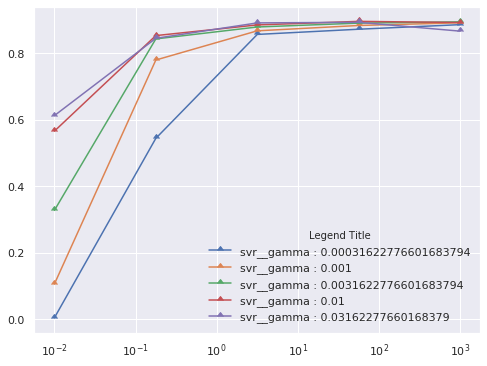

In [130]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


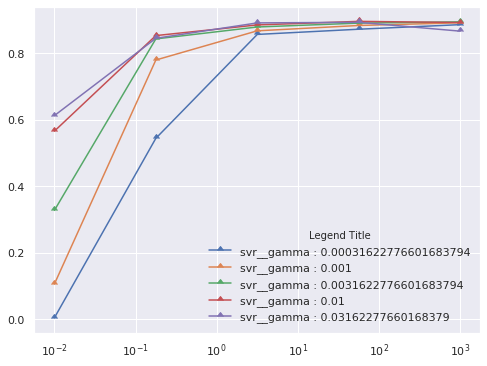

In [131]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [132]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [133]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876],
  [0.8984642754998406, -0.3669699764144684, -0.22054511868325383],
  [0.896394884530667, -0.36993546358051943, -0.21365379000371595]]}

#### modele non linéaire : réseau de neurones

In [134]:

from sklearn.neural_network import MLPRegressor


model_ML = MLPRegressor()

In [135]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'MLPRegressor'

In [136]:

model = make_pipeline(preprocessor,model_ML)
print(model.steps)


[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor',
                                  'ENERGYSTARScore', 'logGFAPark',
                                  'logGFABuild']),
                                (...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  '

In [137]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
    'mlpregressor__learning_rate_init' : np.logspace(-4, -1, 4)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [138]:
grid.cv_results_

{'mean_fit_time': array([0.32950692, 0.62822347, 0.77117743, 1.13183646, 1.33806896,
        1.94100299, 0.30450273, 0.40200791, 0.50350389, 1.07220459,
        1.52563958, 1.80566692, 0.29919839, 0.40801926, 0.44239683,
        0.74174953, 1.00898995, 1.56294875, 0.31814756, 0.53222647,
        0.70240126, 0.97353888, 1.19125376, 1.70966182, 0.43969526,
        0.66670065, 0.86503716, 1.4003665 , 1.86702485, 2.44974189,
        0.46618576, 0.70561957, 0.781181  , 1.1349719 , 1.47397075,
        2.19866443, 0.45486336, 0.68287563, 0.80624452, 1.21869283,
        1.52494469, 2.17097902, 0.47193284, 0.68380713, 0.79048567,
        1.13077798, 1.52328963, 2.14099636, 0.6442842 , 0.93537226,
        1.14618149, 1.70170307, 2.21548452, 3.29725261, 0.61916666,
        0.93530149, 1.1396306 , 1.674648  , 2.25588946, 3.3873765 ,
        0.63402367, 0.92830143, 1.12976346, 1.68539648, 2.21826706,
        3.27454348, 0.66452384, 0.98345976, 1.18858709, 1.69429517,
        2.24673853, 3.51159425]

In [139]:
paramList = list(params.keys())
np.shape(paramList)[0]

5

In [140]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6712894 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de RMSE est : -0.8384171 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de MAE est : -0.6325213 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


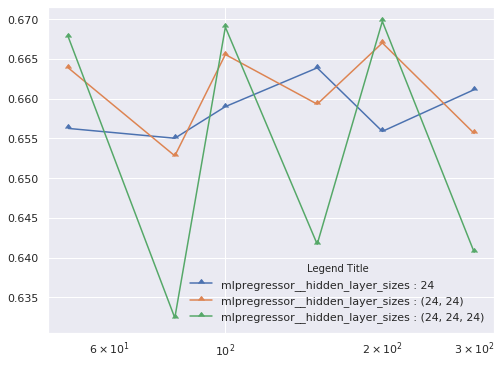

In [141]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


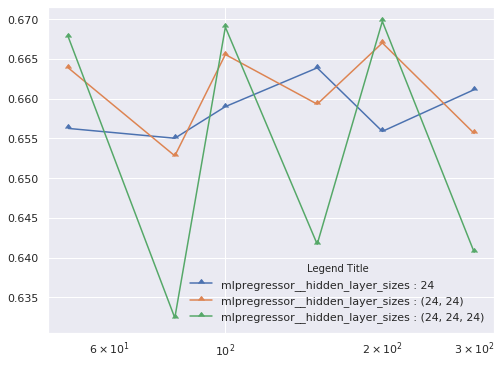

In [142]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


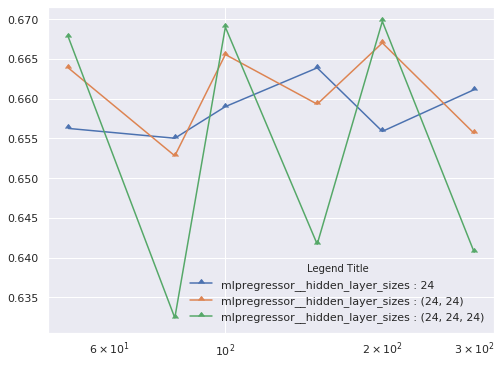

In [143]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [144]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [145]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
  [0.6712893945470811, -0.8384170748170732, -0.6325212567222607]]}

##### Consomation

In [146]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [147]:
grid.cv_results_

{'mean_fit_time': array([0.207023  , 0.42311797, 0.65374293, 0.80287251, 0.86867867,
        1.30911508, 0.44449096, 0.71507759, 0.83801842, 1.15495672,
        1.53819308, 2.28057113, 0.64943233, 0.95444965, 1.1433569 ,
        1.64438834, 2.17430315, 3.24751348]),
 'std_fit_time': array([0.00725238, 0.0983369 , 0.01029632, 0.13430044, 0.01296188,
        0.01474032, 0.01068184, 0.05906764, 0.05511438, 0.01928072,
        0.05431684, 0.06104471, 0.05950809, 0.04482764, 0.02836098,
        0.01695652, 0.02061788, 0.04732017]),
 'mean_score_time': array([0.00788784, 0.01051121, 0.0130734 , 0.01071334, 0.00899229,
        0.00854511, 0.00934916, 0.00898166, 0.00839477, 0.00837064,
        0.00845895, 0.00783806, 0.00881538, 0.00877533, 0.00882497,
        0.0090313 , 0.00861316, 0.00902228]),
 'std_score_time': array([2.88019749e-04, 2.55490334e-03, 2.02031487e-04, 2.06407420e-03,
        9.55428258e-04, 3.36224957e-04, 3.16858109e-04, 6.49335430e-04,
        2.66125180e-04, 2.90031238e-

In [148]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [149]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]
    
    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8915679 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de RMSE est : -0.3793872 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de MAE est : -0.2348823 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : 24


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


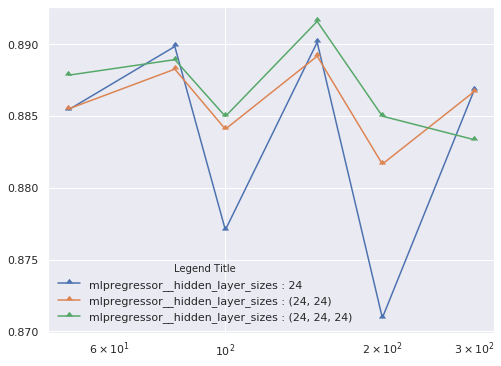

In [150]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


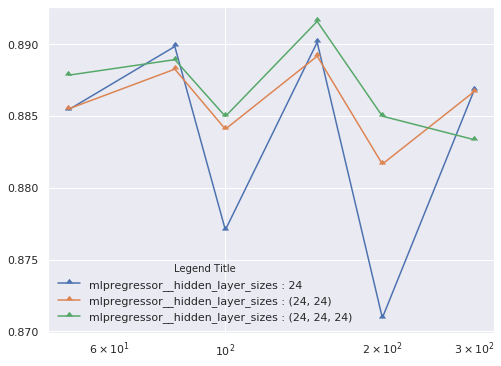

In [151]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


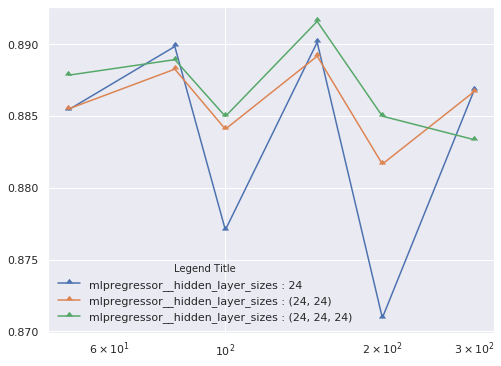

In [152]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [153]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [154]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876],
  [0.8984642754998406, -0.3669699764144684, -0.22054511868325383],
  [0.896394884530667, -0.36993546358051943, -0.21365379000371595],
  [0.8915679204853244, -0.37938715341005647, -0.23488228005909328]]}

#### forêts aléatoires

In [155]:
from sklearn.ensemble import RandomForestRegressor
model_ML = RandomForestRegressor()

In [156]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

In [157]:
model = make_pipeline(preprocessor,model_ML)
print(model.steps)

[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor',
                                  'ENERGYSTARScore', 'logGFAPark',
                                  'logGFABuild']),
                                (...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  '

In [158]:



params = {
            'randomforestregressor__max_depth': [5,10, 15, 20, 22, 24],
            'randomforestregressor__n_estimators': (50, 100),    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [159]:
grid.cv_results_

{'mean_fit_time': array([0.35174952, 0.70042868, 0.62640047, 1.22963347, 0.82742667,
        1.30172982, 0.66997786, 1.33317695, 0.67571774, 1.34629512,
        0.68143792, 1.35159059]),
 'std_fit_time': array([0.00657895, 0.01160521, 0.00882935, 0.00918895, 0.00313081,
        0.14707503, 0.00593724, 0.00990948, 0.00573052, 0.01427584,
        0.00635214, 0.00829706]),
 'mean_score_time': array([0.01142755, 0.0164608 , 0.01458011, 0.02245412, 0.01758413,
        0.02155519, 0.0137557 , 0.02284527, 0.01389055, 0.02326465,
        0.01396561, 0.02328124]),
 'std_score_time': array([0.00025582, 0.00036521, 0.00038945, 0.00053057, 0.00032642,
        0.0008673 , 0.00023884, 0.00039512, 0.00017218, 0.00015085,
        0.00019732, 0.00024347]),
 'param_randomforestregressor__max_depth': masked_array(data=[5, 5, 10, 10, 15, 15, 20, 20, 22, 22, 24, 24],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_val

In [160]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [161]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7724463 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de RMSE est : -0.6972176 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de MAE est : -0.4996379 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


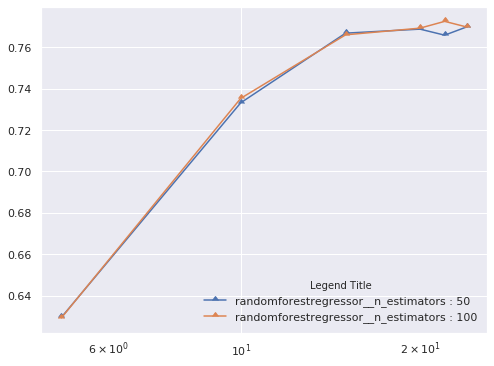

In [162]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


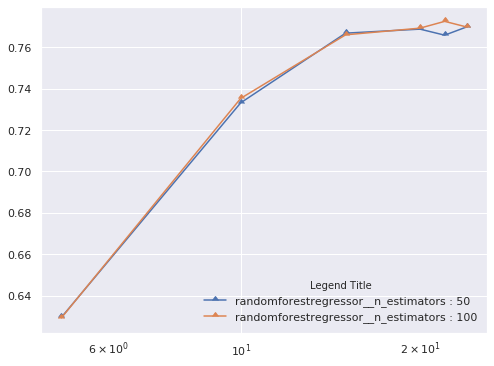

In [163]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


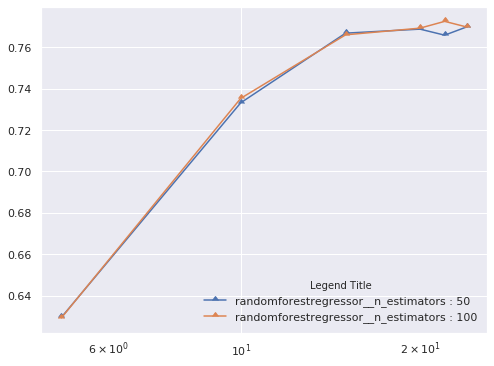

In [164]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [165]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [166]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
  [0.6712893945470811, -0.8384170748170732, -0.6325212567222607],
  [0.7724462629753516, -0.6972176087826988, -0.4996378740353231]]}

##### Consomation

In [167]:



params = {
            'randomforestregressor__max_depth': [5,10, 15, 20, 22, 24],
            'randomforestregressor__n_estimators': (50, 100),    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [168]:
grid.cv_results_

{'mean_fit_time': array([0.36302114, 0.71887159, 0.64665208, 1.24975433, 0.63791661,
        1.2406498 , 0.69133439, 1.37033   , 0.69797487, 1.40138516,
        0.7026978 , 1.39115801]),
 'std_fit_time': array([0.00539773, 0.00807686, 0.00592678, 0.03347251, 0.01566944,
        0.00267269, 0.00957266, 0.0087021 , 0.00429817, 0.01797112,
        0.0028063 , 0.00652447]),
 'mean_score_time': array([0.01158323, 0.01669798, 0.0147099 , 0.02161889, 0.01296296,
        0.02095613, 0.01386552, 0.02291479, 0.01392879, 0.0231576 ,
        0.01408281, 0.0230968 ]),
 'std_score_time': array([2.14133844e-04, 3.12513217e-04, 3.66933750e-04, 1.84251920e-03,
        2.66426659e-04, 2.98203780e-04, 4.18923629e-05, 8.69530045e-05,
        1.80777677e-04, 4.98271558e-04, 8.23363435e-05, 2.58579607e-04]),
 'param_randomforestregressor__max_depth': masked_array(data=[5, 5, 10, 10, 15, 15, 20, 20, 22, 22, 24, 24],
              mask=[False, False, False, False, False, False, False, False,
                 

In [169]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [170]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.9210502 pour les paramètres randomforestregressor__max_depth : 24.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de RMSE est : -0.3234668 pour les paramètres randomforestregressor__max_depth : 24.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de MAE est : -0.1894301 pour les paramètres randomforestregressor__max_depth : 24.0000000 et randomforestregressor__n_estimators : 100.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


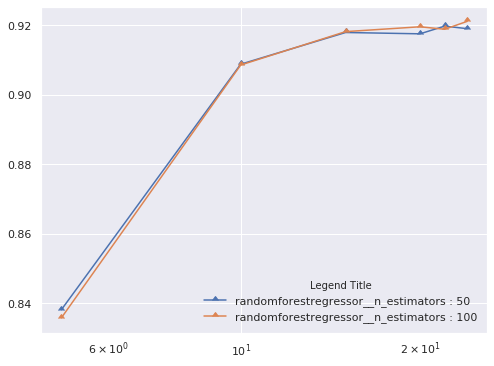

In [171]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


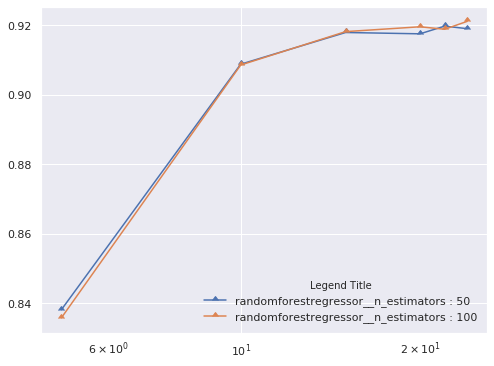

In [172]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


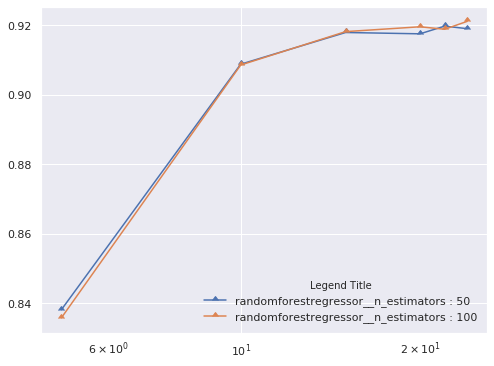

In [173]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [174]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [175]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876],
  [0.8984642754998406, -0.3669699764144684, -0.22054511868325383],
  [0.896394884530667, -0.36993546358051943, -0.21365379000371595],
  [0.8915679204853244, -0.37938715341005647, -0.23488228005909328],
  [0.9210502191904858, -0.3234668234152745, -0.1894301352159678]]}

#### Gradient Boost

In [176]:

from sklearn.ensemble import GradientBoostingRegressor
model_ML = GradientBoostingRegressor()

In [177]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'GradientBoostingRegressor'

In [178]:
model = make_pipeline(preprocessor,model_ML)
model.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('pipeline-1',
                                   Pipeline(memory=None,
                                            steps=[('standardscaler',
                                                    StandardScaler(copy=True,
                                                                   with_mean=True,
                                                                   with_std=True))],
                                            verbose=False),
                                   ['CouncilDistrictCode', 'YearBuilt',
                                    'sqrtNbBuild', 'sqrtNbFloor',
                                    'ENERGYSTARScore', 'logGFAPark',
                                    'logGFABuild']),
                                  (...
                                   ['UType_Hotel', 'UType_K-12 School',
     

In [179]:



params = {
            'gradientboostingregressor__n_estimators': (10, 50, 100, 200, 500),
            'gradientboostingregressor__learning_rate': np.logspace(-5, 0, 5),    
    
    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [180]:
grid.cv_results_

{'mean_fit_time': array([0.06837573, 0.28957696, 0.56575446, 1.12865725, 2.51761885,
        0.04733963, 0.20893211, 0.41019793, 0.80953884, 2.02311177,
        0.0490591 , 0.20928788, 0.41249199, 0.81357913, 2.011269  ,
        0.04902344, 0.20684195, 0.40734   , 0.80236683, 1.98622856,
        0.04830847, 0.20647817, 0.40565362, 0.79978185, 1.98408427]),
 'std_fit_time': array([4.27688339e-04, 4.92232867e-03, 1.21614747e-02, 2.05890794e-02,
        3.27109332e-01, 2.56466652e-04, 3.57415467e-03, 5.06474719e-03,
        5.65480687e-03, 9.17810636e-03, 3.91901475e-04, 3.30323436e-03,
        4.74438427e-03, 7.42947610e-03, 5.90014594e-03, 1.10867500e-04,
        3.26049933e-03, 4.74498514e-03, 6.65334831e-03, 8.47891146e-03,
        7.26037775e-05, 2.50456879e-03, 4.34197336e-03, 5.92907453e-03,
        6.74603624e-03]),
 'mean_score_time': array([0.00642257, 0.00667849, 0.0071239 , 0.00822825, 0.01168275,
        0.0042913 , 0.00480289, 0.00521894, 0.00620427, 0.01042352,
        0.00

In [181]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [182]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7096049 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de RMSE est : -0.7879687 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de MAE est : -0.5510667 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 1.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


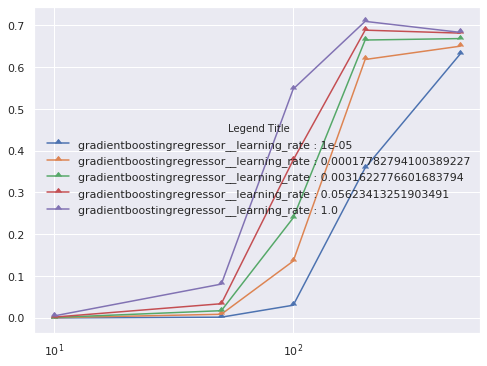

In [183]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


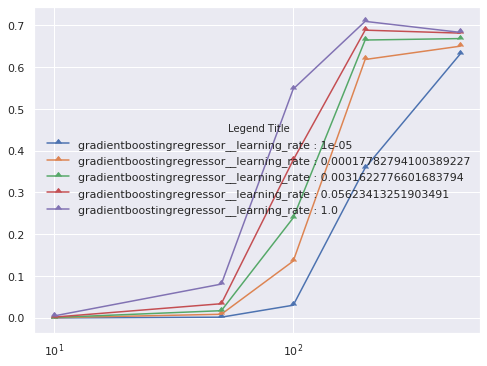

In [184]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


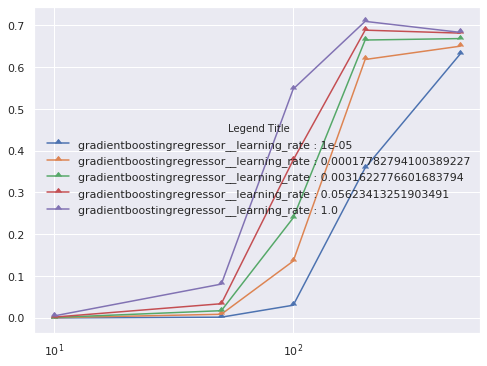

In [185]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [186]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [187]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
  [0.6712893945470811, -0.8384170748170732, -0.6325212567222607],
  [0.7724462629753516, -0.6972176087826988, -0.4996378740353231],
  [0.7096048704619445, -0.7879687397101925, -0.551066701924657]]}

##### Consomation

In [188]:



params = {
            'gradientboostingregressor__n_estimators': (10, 50, 100, 200, 500),
            'gradientboostingregressor__learning_rate': np.logspace(-5, 0, 5),    
    
    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [189]:
grid.cv_results_

{'mean_fit_time': array([0.06828642, 0.29023619, 0.57372236, 1.12498436, 2.19570322,
        0.04909863, 0.2086308 , 0.40882688, 0.81404781, 2.02411809,
        0.04786177, 0.2109314 , 0.41173978, 0.81500444, 2.01714058,
        0.04911094, 0.20711455, 0.40351052, 0.80208931, 1.9850266 ,
        0.04800191, 0.20670314, 0.40325136, 0.79811273, 1.97831979]),
 'std_fit_time': array([2.86405403e-04, 3.75037163e-03, 6.89013499e-03, 8.53604135e-03,
        3.04850435e-01, 6.54662167e-05, 3.44471133e-03, 4.35247437e-03,
        7.20653958e-03, 7.11911389e-03, 6.77177624e-04, 2.97594720e-03,
        4.13101048e-03, 7.20792575e-03, 5.41085699e-03, 7.97455655e-05,
        2.91482296e-03, 4.20867879e-03, 7.81952655e-03, 1.55400882e-02,
        5.86120655e-04, 2.95675573e-03, 4.28197620e-03, 6.71917627e-03,
        4.79518373e-03]),
 'mean_score_time': array([0.00648332, 0.00673733, 0.00711222, 0.00814252, 0.00795622,
        0.00444279, 0.00477405, 0.00529857, 0.00605884, 0.00899444,
        0.00

In [190]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [191]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.9134487 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de RMSE est : -0.3383789 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de MAE est : -0.2083958 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


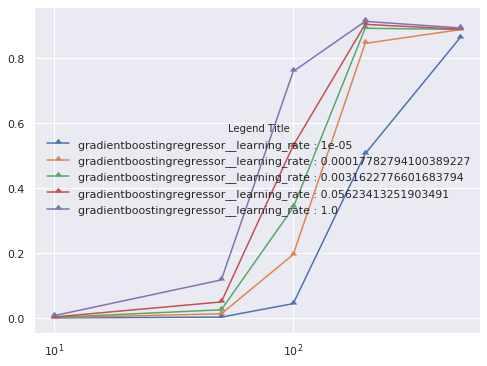

In [192]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


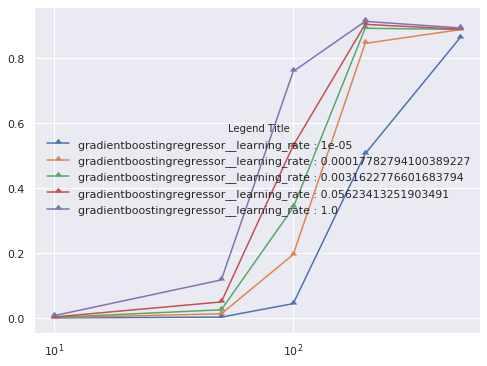

In [193]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


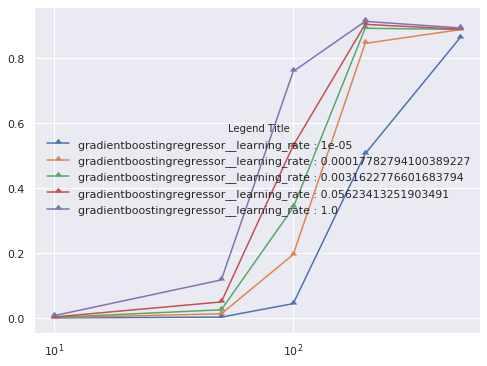

In [194]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [195]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

### Résultats

#### Emission

In [196]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
  [0.6712893945470811, -0.8384170748170732, -0.6325212567222607],
  [0.7724462629753516, -0.6972176087826988, -0.4996378740353231],
  [0.7096048704619445, -0.7879687397101925, -0.551066701924657]]}

In [197]:
ERROR_EMI["Resuts"]

[[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
 [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
 [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
 [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
 [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
 [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
 [0.6712893945470811, -0.8384170748170732, -0.6325212567222607],
 [0.7724462629753516, -0.6972176087826988, -0.4996378740353231],
 [0.7096048704619445, -0.7879687397101925, -0.551066701924657]]

In [198]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(abs(ERROR_EMI["Resuts"][k][l]))
        model.append(ERROR_EMI["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_EMI["type d'erreur"]*np.shape(ERROR_EMI["Modèle"])[0],
    "Résutats d'émission": result
}
d

{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 "Résutats d'émission": [0.5903892450657768,
  0.9360766198046677,
  0.7653914609296357,
  0.5904470284942284,
  0.9360156341433463,
  0.7652966493692456,
  0.6506073644082123,
  0.8642158771299071

In [199]:
resultatEMI= pd.DataFrame(data=d)
resultatEMI

Modèle type d'erreur  Résutats d'émission
0            LinearRegression            R2             0.590389
1            LinearRegression          RMSE             0.936077
2            LinearRegression           MAE             0.765391
3                  ElasticNet            R2             0.590447
4                  ElasticNet          RMSE             0.936016
5                  ElasticNet           MAE             0.765297
6                      SVRlin            R2             0.650607
7                      SVRlin          RMSE             0.864216
8                      SVRlin           MAE             0.609023
9         KNeighborsRegressor            R2             0.589094
10        KNeighborsRegressor          RMSE             0.937936
11        KNeighborsRegressor           MAE             0.555844
12                KernelRidge            R2             0.653407
13                KernelRidge          RMSE             0.861024
14                KernelRidge           MAE             0.643237
15                        SVR            R2             0.648494
16                        SVR          RMSE             0.866794
17                        SVR           MAE             0.616607
18               MLPRegressor            R2             0.671289
19               MLPRegressor          RMSE             0.838417
20               MLPRegressor           MAE             0.632521
21      RandomForestRegressor            R2             0.772446
22      RandomForestRegressor          RMSE             0.697218
23      RandomForestRegressor           MAE             0.499638
24  GradientBoostingRegressor            R2             0.709605
25  GradientBoostingRegressor          RMSE             0.787969
26  GradientBoostingRegressor           MAE             0.551067

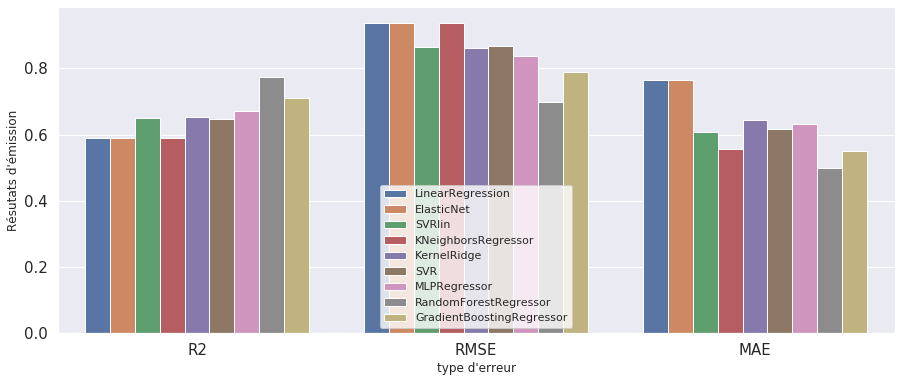

In [200]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(loc='lower center')

In [201]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5903892450657768, -0.9360766198046677, -0.7653914609296357],
  [0.5904470284942284, -0.9360156341433463, -0.7652966493692456],
  [0.6506073644082123, -0.8642158771299071, -0.6090226947069508],
  [0.5890938086224354, -0.9379356967497529, -0.5558439901780163],
  [0.6534065569103185, -0.8610242552942315, -0.6432367023944663],
  [0.648494075746451, -0.8667941227012326, -0.6166073107326584],
  [0.6712893945470811, -0.8384170748170732, -0.6325212567222607],
  [0.7724462629753516, -0.6972176087826988, -0.4996378740353231],
  [0.7096048704619445, -0.7879687397101925, -0.551066701924657]]}

#### Consomation

In [202]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8651614118459812, -0.42297040671892405, -0.2703386164281777],
  [0.8653155860563405, -0.42271086636092764, -0.26765325589882855],
  [0.8912280607071861, -0.3798999747038394, -0.21560212511347432],
  [0.8073276125079258, -0.5066615732437934, -0.27974936427331876],
  [0.8984642754998406, -0.3669699764144684, -0.22054511868325383],
  [0.896394884530667, -0.36993546358051943, -0.21365379000371595],
  [0.8915679204853244, -0.37938715341005647, -0.23488228005909328],
  [0.9210502191904858, -0.3234668234152745, -0.1894301352159678],
  [0.9134487252574655, -0.33837893128398816, -0.2083958021502791]]}

In [203]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(abs(ERROR_CONSO["Resuts"][k][l]))
        model.append(ERROR_CONSO["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_CONSO["type d'erreur"]*np.shape(ERROR_CONSO["Modèle"])[0],
    "Résutats de consomation": result
}
d


{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 'Résutats de consomation': [0.8651614118459812,
  0.42297040671892405,
  0.2703386164281777,
  0.8653155860563405,
  0.42271086636092764,
  0.26765325589882855,
  0.8912280607071861,
  0.379899974

In [204]:
resultatCONSO= pd.DataFrame(data=d)
resultatCONSO

Modèle type d'erreur  Résutats de consomation
0            LinearRegression            R2                 0.865161
1            LinearRegression          RMSE                 0.422970
2            LinearRegression           MAE                 0.270339
3                  ElasticNet            R2                 0.865316
4                  ElasticNet          RMSE                 0.422711
5                  ElasticNet           MAE                 0.267653
6                      SVRlin            R2                 0.891228
7                      SVRlin          RMSE                 0.379900
8                      SVRlin           MAE                 0.215602
9         KNeighborsRegressor            R2                 0.807328
10        KNeighborsRegressor          RMSE                 0.506662
11        KNeighborsRegressor           MAE                 0.279749
12                KernelRidge            R2                 0.898464
13                KernelRidge          RMSE                 0.366970
14                KernelRidge           MAE                 0.220545
15                        SVR            R2                 0.896395
16                        SVR          RMSE                 0.369935
17                        SVR           MAE                 0.213654
18               MLPRegressor            R2                 0.891568
19               MLPRegressor          RMSE                 0.379387
20               MLPRegressor           MAE                 0.234882
21      RandomForestRegressor            R2                 0.921050
22      RandomForestRegressor          RMSE                 0.323467
23      RandomForestRegressor           MAE                 0.189430
24  GradientBoostingRegressor            R2                 0.913449
25  GradientBoostingRegressor          RMSE                 0.338379
26  GradientBoostingRegressor           MAE                 0.208396

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

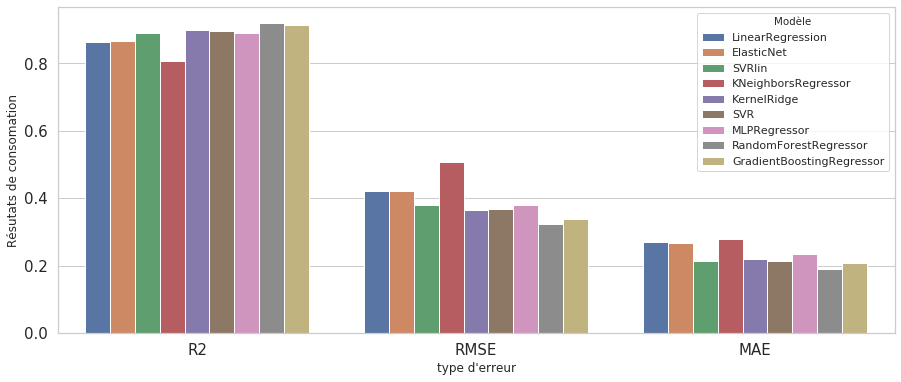

In [205]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#### Save result Star

In [206]:
resultatEMI.to_csv('resultatEMI.csv', sep='\t', encoding='utf-8')
resultatCONSO.to_csv('resultatCONSO.csv', sep='\t', encoding='utf-8')


In [207]:
data

OSEBuildingID  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
0                 1                    7       1927                1.0   
1                 2                    7       1996                1.0   
2                 3                    7       1969                1.0   
3                 5                    7       1926                1.0   
4                 8                    7       1980                1.0   
...             ...                  ...        ...                ...   
6512          50222                    2       1990                1.0   
6513          50223                    2       2004                1.0   
6514          50224                    7       1974                1.0   
6515          50225                    1       1989                1.0   
6516          50226                    2       1938                1.0   

      NumberofFloors  PropertyGFAParking  PropertyGFABuilding(s)  \
0               12.0                   1                   88434   
1               11.0               15064                   88502   
2               41.0                   1                  961990   
3               10.0                   1                   61320   
4               18.0               12460                  107430   
...              ...                 ...                     ...   
6512             1.0                   1                   12294   
6513             1.0                   1                   16000   
6514             1.0                   1                   13157   
6515             1.0                   1                   14101   
6516             1.0                   1                   18258   

      ENERGYSTARScore  GHGEmissions(MetricTonsCO2e)  ConsoSourceBrute  ...  \
0                65.0                        249.43      1.534330e+07  ...   
1                51.0                        263.51      1.981218e+07  ...   
2                18.0                       2061.48      2.334750e+08  ...   
3                 1.0                       1936.34      3.901792e+07  ...   
4                67.0                        507.70      2.743083e+07  ...   
...               ...                           ...               ...  ...   
6512             46.0                         20.94      1.987940e+06  ...   
6513              NaN                         32.17      1.827200e+06  ...   
6514              NaN                        223.54      9.799333e+06  ...   
6515              NaN                         22.11      1.484835e+06  ...   
6516              NaN                         41.27      2.114276e+06  ...   

      UType_Other  UType_Parking  UType_Restaurant  UType_Retail Store  \
0             0.0            0.0               0.0                 0.0   
1             0.0            2.0               1.0                 0.0   
2             0.0            2.0               0.0                 0.0   
3             0.0            0.0               0.0                 0.0   
4             0.0            2.0               0.0                 0.0   
...           ...            ...               ...                 ...   
6512          0.0            0.0               0.0                 0.0   
6513          0.0            0.0               0.0                 0.0   
6514          0.0            0.0               0.0                 0.0   
6515          0.0            0.0               0.0                 0.0   
6516          0.0            0.0               0.0                 0.0   

      BType_Multifamily HR (10+)  BType_Multifamily LR (1-4)  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
6512                      

## étude sans ENERGY STAR

In [208]:
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [209]:
dataNoStar.shape

(6515, 30)

In [210]:
dataNoStar.columns

Index(['OSEBuildingID', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'GHGEmissions(MetricTonsCO2e)',
       'ConsoSourceBrute', 'logEMI', 'logCONSO', 'sqrtNbFloor', 'sqrtNbBuild',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

In [211]:
categorical_features = dataNoStar.columns[15 :].to_list()
categorical_features

['UType_Hotel',
 'UType_K-12 School',
 'UType_Multifamily Housing',
 'UType_Non-Refrigerated Warehouse',
 'UType_Office',
 'UType_Other',
 'UType_Parking',
 'UType_Restaurant',
 'UType_Retail Store',
 'BType_Multifamily HR (10+)',
 'BType_Multifamily LR (1-4)',
 'BType_Multifamily MR (5-9)',
 'BType_NonResidential',
 'BType_Nonresidential COS',
 'BType_SPS-District K-12']

### Isolation d'un set de données test X_test_noStar et y_test

In [212]:
from sklearn.model_selection import train_test_split

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'logGFAPark', 'logGFABuild']

categorical_features = dataNoStar.columns[15:].to_list()


X = dataNoStar[numerical_features + categorical_features]
y = dataNoStar[[targetEMI] + [targetCONSO]]

X_train_noStar, X_test_noStar, Y_train_noStar, Y_test_noStar = train_test_split(X, y, test_size=0.2)
print(X_train_noStar.shape)
print(X_test_noStar.shape)
print(Y_train_noStar.shape)
print(Y_test_noStar.shape)

(5212, 21)
(1303, 21)
(5212, 2)
(1303, 2)


In [213]:
Y_train_noStarCONSO = Y_train_noStar[targetCONSO]
Y_train_noStarEMI = Y_train_noStar[targetEMI]

print(Y_train_noStarCONSO.shape)
print(Y_train_noStarEMI.shape)

(5212,)
(5212,)


In [214]:
X_train_noStar.to_csv('X_train_noStar.csv', sep='\t', encoding='utf-8')
Y_train_noStar.to_csv('Y_train_noStar.csv', sep='\t', encoding='utf-8')

X_test_noStar.to_csv('X_test_noStar.csv', sep='\t', encoding='utf-8')
Y_test_noStar.to_csv('Y_test_noStar.csv', sep='\t', encoding='utf-8')

### creation pipeline transformer

In [215]:
X_train_noStar.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

In [216]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [217]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

### Evaluation des modèles avec validation croisées et comparaison avec eds approche de regression naives

#### Initialisation tableau ERROR

In [218]:
ERROR_EMI_noStar = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
ERROR_CONSO_noStar = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

#### modele linéaire 

In [219]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS


model_ML = LinearRegression()


In [220]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'LinearRegression'

##### Emission

In [221]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train_noStar , Y_train_noStar)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [222]:
grid.cv_results_

{'mean_fit_time': array([0.01633358]),
 'std_fit_time': array([0.00093947]),
 'mean_score_time': array([0.00749645]),
 'std_score_time': array([0.00065008]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-1.05926656]),
 'split1_test_neg_root_mean_squared_error': array([-1.03868597]),
 'split2_test_neg_root_mean_squared_error': array([-1.04138806]),
 'split3_test_neg_root_mean_squared_error': array([-1.02252163]),
 'split4_test_neg_root_mean_squared_error': array([-1.07103176]),
 'mean_test_neg_root_mean_squared_error': array([-1.0465788]),
 'std_test_neg_root_mean_squared_error': array([0.01689328]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.53655071]),
 'split1_test_r2': array([0.52497167]),
 'split2_test_r2': array([0.46099958]),
 'split3_test_r2': array([0.52941758]),
 'split4_test_r2': array([0.50447578]),
 'mean_test_r2': array([0.51128307]),
 'std_test_r2': array([0.02731102]),
 'rank_test_r2': array([1], 

In [223]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [224]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [225]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607]]}

##### Consomation

In [226]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train_noStar , Y_train_noStar)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [227]:
grid.cv_results_

{'mean_fit_time': array([0.01812005]),
 'std_fit_time': array([0.00030122]),
 'mean_score_time': array([0.00816946]),
 'std_score_time': array([0.00019208]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.60217889]),
 'split1_test_neg_root_mean_squared_error': array([-0.56990543]),
 'split2_test_neg_root_mean_squared_error': array([-0.5998753]),
 'split3_test_neg_root_mean_squared_error': array([-0.59066134]),
 'split4_test_neg_root_mean_squared_error': array([-0.60164475]),
 'mean_test_neg_root_mean_squared_error': array([-0.59285314]),
 'std_test_neg_root_mean_squared_error': array([0.01220635]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.75828442]),
 'split1_test_r2': array([0.76878457]),
 'split2_test_r2': array([0.73215632]),
 'split3_test_r2': array([0.75486119]),
 'split4_test_r2': array([0.74380903]),
 'mean_test_r2': array([0.75157911]),
 'std_test_r2': array([0.01256487]),
 'rank_test_r2': array([1], 

In [228]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [229]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [230]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126]]}

#### modele linaire avec Elastic Net

In [231]:
from sklearn.linear_model import ElasticNet

model_ML = ElasticNet()


In [232]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'ElasticNet'

In [233]:
model = make_pipeline(preprocessor,model_ML)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [234]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2251.2670774345324, tolerance: 0.9194962229675164
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2271.603432956319, tolerance: 0.9351325701250386
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270.702108185846, tolerance: 0.9621887128245838
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the num

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [235]:
paramList = list(params.keys())


In [236]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.5113204 pour les paramètres alpha 0.0010000 et l1_ratio 0.5000000

Le meilleur score de RMSE est : -1.0465413 pour les paramètres alpha 0.0010000 et l1_ratio 0.5000000

Le meilleur score de MAE est : -0.8353353 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000


In [237]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


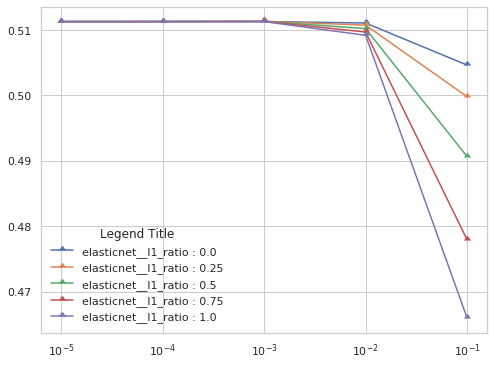

In [238]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


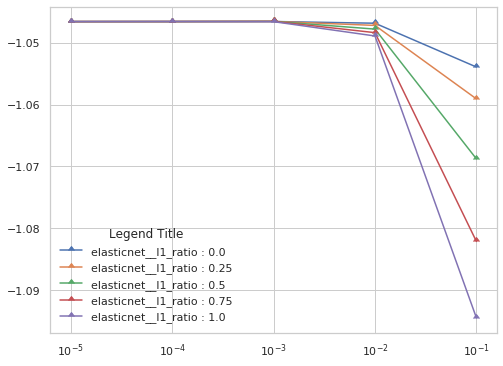

In [239]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


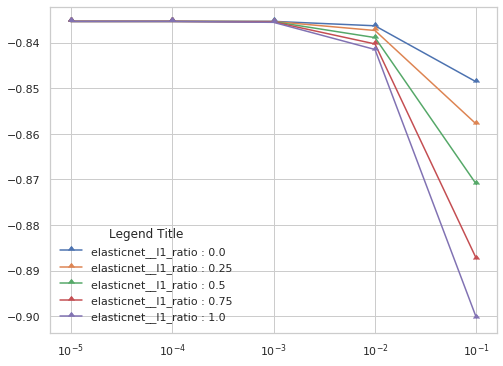

In [240]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [241]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [242]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753]]}

##### Consomation

In [243]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.5356465771397, tolerance: 0.5823514802661541
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.6622319854159, tolerance: 0.5921715220644564
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 721.5400643467459, tolerance: 0.598795236813767
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [244]:
paramList = list(params.keys())


In [245]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.7515896 pour les paramètres alpha 0.0001000 et l1_ratio 1.0000000

Le meilleur score de RMSE est : -0.5928390 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de MAE est : -0.3997464 pour les paramètres alpha 0.0100000 et l1_ratio 0.7500000


In [246]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


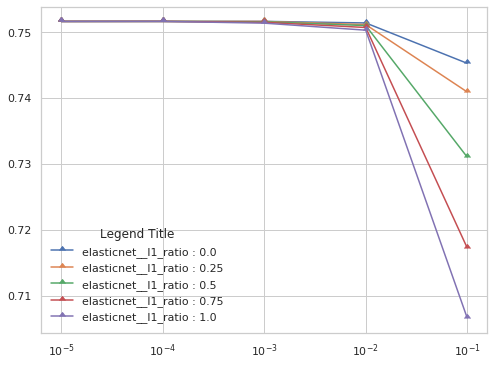

In [247]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


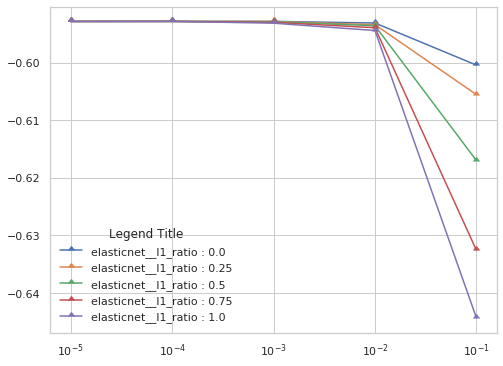

In [248]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


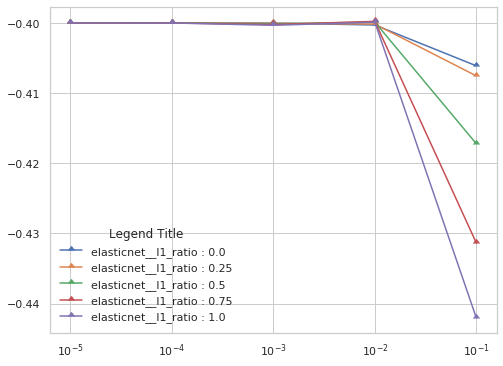

In [249]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [250]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [251]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875]]}

#### modele linaire avec SVR

In [252]:
from sklearn.svm import SVR
model_ML = SVR()

In [253]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0) + "lin"
model_name

'SVRlin'

In [254]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [255]:

params = {
    "svr__C" : np.logspace(-1, 2, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [256]:
grid.cv_results_

{'mean_fit_time': array([1.73252859, 1.76948237, 2.03109746, 3.10108833, 6.37980442]),
 'std_fit_time': array([0.01028337, 0.02283206, 0.03531392, 0.05124381, 1.17137722]),
 'mean_score_time': array([0.24056072, 0.23545289, 0.22729826, 0.21962266, 0.17358079]),
 'std_score_time': array([0.00107128, 0.0008761 , 0.00132346, 0.00350769, 0.02620848]),
 'param_svr__C': masked_array(data=[0.1, 0.5623413251903491, 3.1622776601683795,
                    17.78279410038923, 100.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.1},
  {'svr__C': 0.5623413251903491},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 17.78279410038923},
  {'svr__C': 100.0}],
 'split0_test_neg_root_mean_squared_error': array([-1.0873042 , -1.02208586, -0.99281355, -0.98849641, -1.00388827]),
 'split1_test_neg_root_mean_squared_error': array([-1.03398538, -0.98726332, -0.97740181, -0.98791323, -1.01693017]),
 'split2_test_neg_root_mea

In [257]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [258]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5785748 pour les paramètres svr__C : 17.7827941

Le meilleur score de RMSE est : -0.9723148 pour les paramètres svr__C : 17.7827941

Le meilleur score de MAE est : -0.6876534 pour les paramètres svr__C : 17.7827941


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


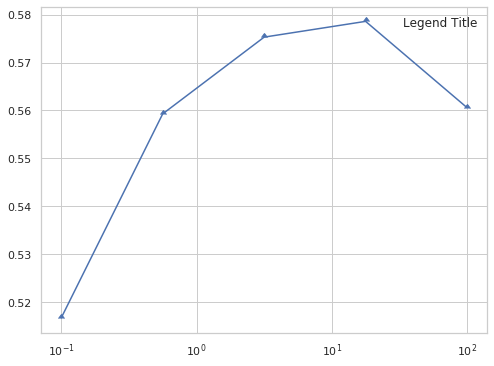

In [259]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


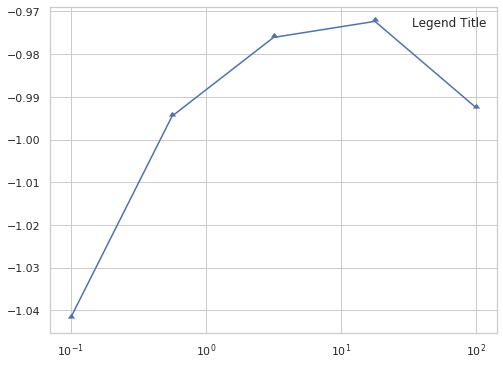

In [260]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


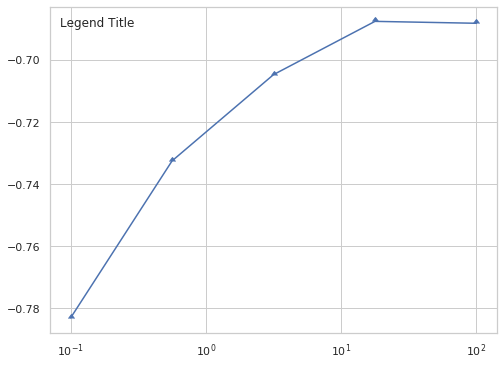

In [261]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [262]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [263]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807]]}

##### Consomation

In [264]:

params = {
    "svr__C" : np.logspace(-2, 3, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [265]:
grid.cv_results_

{'mean_fit_time': array([ 1.68640943,  1.16785526,  1.410993  ,  4.80991387, 50.84551868]),
 'std_fit_time': array([0.04519478, 0.05291042, 0.02075501, 0.27168862, 1.81748397]),
 'mean_score_time': array([0.22370629, 0.15071187, 0.14016223, 0.1414959 , 0.13511076]),
 'std_score_time': array([0.00852105, 0.00163669, 0.00301592, 0.01422691, 0.00126764]),
 'param_svr__C': masked_array(data=[0.01, 0.1778279410038923, 3.1622776601683795,
                    56.23413251903491, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.01},
  {'svr__C': 0.1778279410038923},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 56.23413251903491},
  {'svr__C': 1000.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.85620501, -0.64806179, -0.59250291, -0.60871066, -0.71784006]),
 'split1_test_neg_root_mean_squared_error': array([-0.78945061, -0.5779354 , -0.53758123, -0.57510524, -0.68643039]),
 'split2_test_neg

In [266]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [267]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7788131 pour les paramètres svr__C : 3.1622777

Le meilleur score de RMSE est : -0.5597400 pour les paramètres svr__C : 3.1622777

Le meilleur score de MAE est : -0.3560065 pour les paramètres svr__C : 3.1622777


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


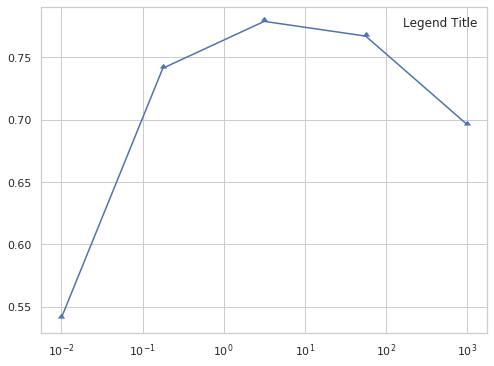

In [268]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


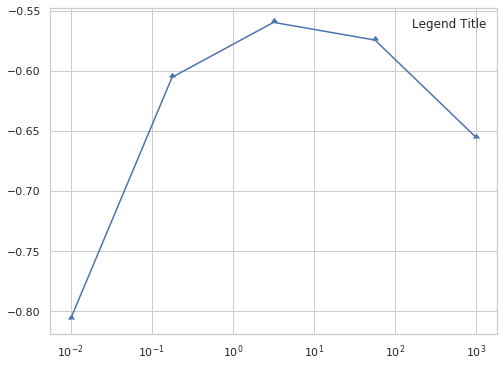

In [269]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


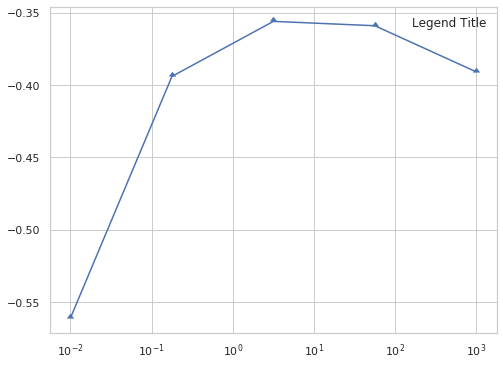

In [270]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [271]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [272]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124]]}

#### modele KNN 

In [273]:
from sklearn.neighbors import KNeighborsRegressor
model_ML = KNeighborsRegressor()

In [274]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KNeighborsRegressor'

In [275]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [276]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,40),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [277]:
grid.cv_results_

{'mean_fit_time': array([0.04827619, 0.04921784, 0.04845409, 0.04760251, 0.04695816,
        0.04672198, 0.04677162, 0.04695802, 0.0467896 , 0.04730721,
        0.04619627, 0.03986611, 0.03515549, 0.0334497 , 0.03362026,
        0.03360457, 0.03332834, 0.03299356, 0.03365216, 0.03348632,
        0.03306742, 0.03349366, 0.03354263, 0.03350334, 0.03344159,
        0.03279443, 0.03336349, 0.03348508, 0.03355021, 0.03366942,
        0.0351932 , 0.03875675, 0.03927665, 0.0395071 , 0.03933892,
        0.03945274, 0.03955879, 0.03937368, 0.0392992 ]),
 'std_fit_time': array([0.00332395, 0.00094655, 0.00247181, 0.00161054, 0.00123402,
        0.00133316, 0.00099915, 0.00084049, 0.00101736, 0.00126154,
        0.00195968, 0.0039968 , 0.00148144, 0.00072604, 0.00132091,
        0.00086847, 0.00101944, 0.00073832, 0.00085369, 0.00086992,
        0.00116104, 0.00086816, 0.00103735, 0.00085542, 0.00103714,
        0.00119688, 0.00091779, 0.00094464, 0.00057288, 0.00105727,
        0.00168649, 0.000

In [278]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [279]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5684945 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de RMSE est : -0.9840202 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de MAE est : -0.5705275 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


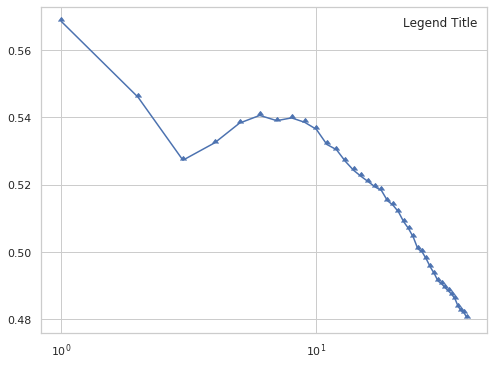

In [280]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


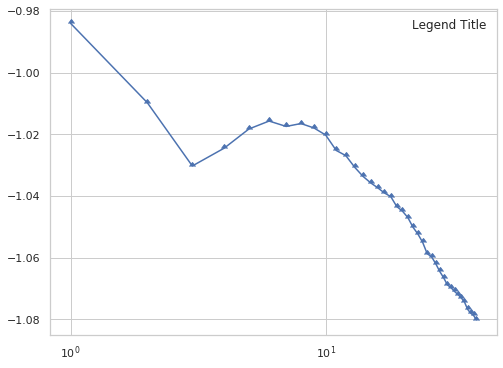

In [281]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


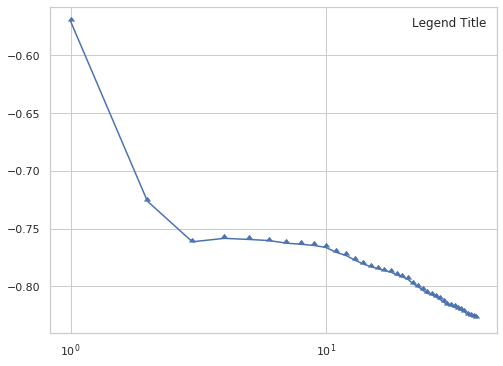

In [282]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [283]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [284]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487]]}

##### Consomation

In [285]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,20),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [286]:
grid.cv_results_

{'mean_fit_time': array([0.05267329, 0.05252047, 0.05326366, 0.05293679, 0.05325255,
        0.05119348, 0.05180221, 0.05168033, 0.05279245, 0.04173479,
        0.03859906, 0.0377975 , 0.03791761, 0.0378108 , 0.03732486,
        0.03750486, 0.03794365, 0.03723845, 0.03789935]),
 'std_fit_time': array([0.00157668, 0.00168848, 0.00358517, 0.00235653, 0.00193283,
        0.00194333, 0.00198636, 0.00170712, 0.00506182, 0.00249981,
        0.00124044, 0.00097452, 0.00091887, 0.00111874, 0.0013338 ,
        0.00043875, 0.00090283, 0.00078135, 0.00095857]),
 'mean_score_time': array([0.13144913, 0.14833317, 0.15781732, 0.16184011, 0.16387377,
        0.1647933 , 0.16776133, 0.1696557 , 0.17420483, 0.14351101,
        0.13470321, 0.13377686, 0.13542137, 0.13619609, 0.13521132,
        0.13824406, 0.13863192, 0.13894281, 0.14147806]),
 'std_score_time': array([0.0051438 , 0.0040423 , 0.00956426, 0.00574984, 0.00382649,
        0.00530702, 0.00593859, 0.00545792, 0.01560505, 0.00733169,
        

In [287]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [288]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7388519 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de RMSE est : -0.6081199 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de MAE est : -0.3250529 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


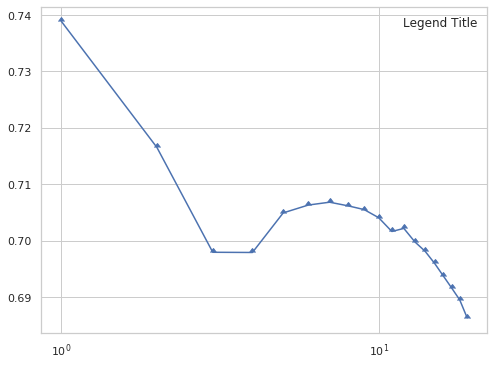

In [289]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


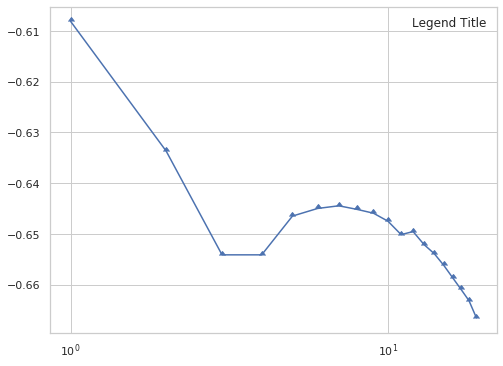

In [290]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


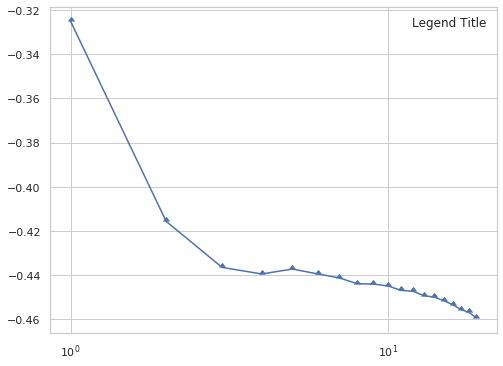

In [291]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [292]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [293]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026]]}

#### modele non linéaire La régression ridge à noyau

In [294]:
from sklearn import kernel_ridge
model_ML = kernel_ridge.KernelRidge()
       

In [295]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KernelRidge'

In [296]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [297]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [298]:
grid.cv_results_

{'mean_fit_time': array([1.11760464, 1.18200326, 1.13989806, 1.13707137, 1.14555488,
        1.01553159, 0.98760548, 0.99204278, 0.99015412, 1.00135107,
        0.9959166 , 0.99723229, 0.99751592, 0.99784975, 0.996982  ,
        0.99652138, 0.99412708, 1.00010643, 0.99479542, 0.99542913,
        0.99446197, 0.99442048, 0.99484224, 0.99871936, 0.99305396]),
 'std_fit_time': array([0.05880047, 0.04860517, 0.01725383, 0.01303031, 0.02746414,
        0.0536612 , 0.0154742 , 0.0117369 , 0.01315477, 0.01123307,
        0.01338223, 0.01089719, 0.01742323, 0.00994607, 0.01176659,
        0.01099889, 0.01289838, 0.01030704, 0.01147878, 0.01418545,
        0.01068652, 0.01481006, 0.01437901, 0.01502271, 0.01620184]),
 'mean_score_time': array([0.08949466, 0.09066396, 0.09069128, 0.09109335, 0.09093876,
        0.08059821, 0.08087745, 0.08095183, 0.08061419, 0.08124032,
        0.0807972 , 0.08172898, 0.08070259, 0.08083386, 0.08074346,
        0.0805584 , 0.08059092, 0.08092771, 0.08063116, 0.08

In [299]:
grid.cv_results_

{'mean_fit_time': array([1.11760464, 1.18200326, 1.13989806, 1.13707137, 1.14555488,
        1.01553159, 0.98760548, 0.99204278, 0.99015412, 1.00135107,
        0.9959166 , 0.99723229, 0.99751592, 0.99784975, 0.996982  ,
        0.99652138, 0.99412708, 1.00010643, 0.99479542, 0.99542913,
        0.99446197, 0.99442048, 0.99484224, 0.99871936, 0.99305396]),
 'std_fit_time': array([0.05880047, 0.04860517, 0.01725383, 0.01303031, 0.02746414,
        0.0536612 , 0.0154742 , 0.0117369 , 0.01315477, 0.01123307,
        0.01338223, 0.01089719, 0.01742323, 0.00994607, 0.01176659,
        0.01099889, 0.01289838, 0.01030704, 0.01147878, 0.01418545,
        0.01068652, 0.01481006, 0.01437901, 0.01502271, 0.01620184]),
 'mean_score_time': array([0.08949466, 0.09066396, 0.09069128, 0.09109335, 0.09093876,
        0.08059821, 0.08087745, 0.08095183, 0.08061419, 0.08124032,
        0.0807972 , 0.08172898, 0.08070259, 0.08083386, 0.08074346,
        0.0805584 , 0.08059092, 0.08092771, 0.08063116, 0.08

In [300]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [301]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5857702 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de RMSE est : -0.9642473 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de MAE est : -0.7157910 pour les paramètres kernelridge__alpha : 0.0031623 et kernelridge__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


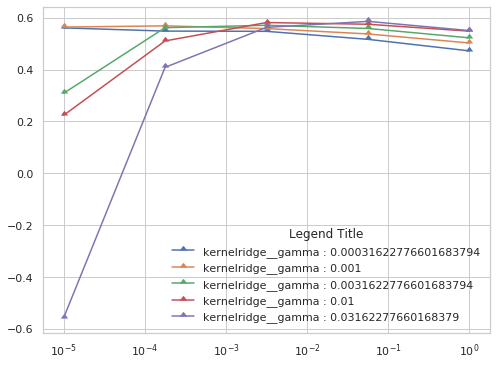

In [302]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


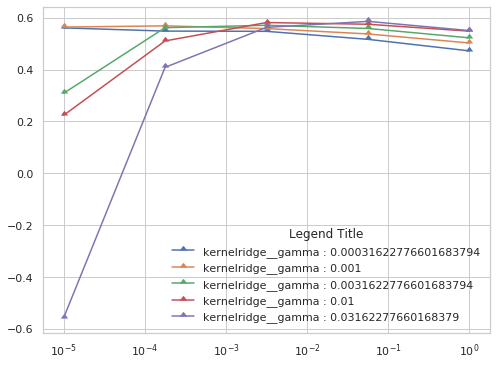

In [303]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


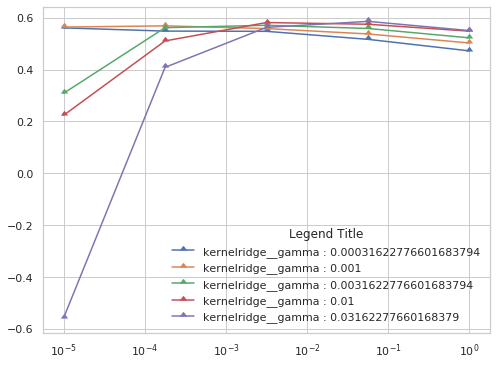

In [304]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [305]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [306]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487],
  [0.5857701588317937, -0.9642473010582634, -0.7157909663835565]]}

##### Consomation 

In [307]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [308]:
grid.cv_results_

{'mean_fit_time': array([1.26703463, 1.29190106, 0.9961853 , 1.01625566, 0.99324837,
        0.99649925, 0.99066501, 0.99498897, 0.99268503, 0.99149928,
        0.99104753, 0.99098854, 0.9920022 , 0.98978758, 0.99252915,
        1.00626302, 0.99004655, 0.98836803, 0.98961477, 0.99034986,
        0.98705115, 0.9919898 , 0.99032292, 0.99368753, 0.99341474]),
 'std_fit_time': array([0.07931012, 0.04774943, 0.01559234, 0.04291005, 0.01302677,
        0.00808848, 0.00853962, 0.01258289, 0.01399533, 0.01339996,
        0.01325825, 0.01353549, 0.01346184, 0.01167214, 0.0105147 ,
        0.01090761, 0.01409163, 0.01443734, 0.01136247, 0.01497697,
        0.01408731, 0.01539641, 0.01267523, 0.01035858, 0.01450751]),
 'mean_score_time': array([0.09388738, 0.08898616, 0.08096809, 0.08106518, 0.08071346,
        0.08123798, 0.08092599, 0.0807106 , 0.08087788, 0.08070374,
        0.08064919, 0.0810535 , 0.08061552, 0.08147244, 0.08087564,
        0.08145213, 0.08070121, 0.08089409, 0.08325472, 0.08

In [309]:
grid.cv_results_

{'mean_fit_time': array([1.26703463, 1.29190106, 0.9961853 , 1.01625566, 0.99324837,
        0.99649925, 0.99066501, 0.99498897, 0.99268503, 0.99149928,
        0.99104753, 0.99098854, 0.9920022 , 0.98978758, 0.99252915,
        1.00626302, 0.99004655, 0.98836803, 0.98961477, 0.99034986,
        0.98705115, 0.9919898 , 0.99032292, 0.99368753, 0.99341474]),
 'std_fit_time': array([0.07931012, 0.04774943, 0.01559234, 0.04291005, 0.01302677,
        0.00808848, 0.00853962, 0.01258289, 0.01399533, 0.01339996,
        0.01325825, 0.01353549, 0.01346184, 0.01167214, 0.0105147 ,
        0.01090761, 0.01409163, 0.01443734, 0.01136247, 0.01497697,
        0.01408731, 0.01539641, 0.01267523, 0.01035858, 0.01450751]),
 'mean_score_time': array([0.09388738, 0.08898616, 0.08096809, 0.08106518, 0.08071346,
        0.08123798, 0.08092599, 0.0807106 , 0.08087788, 0.08070374,
        0.08064919, 0.0810535 , 0.08061552, 0.08147244, 0.08087564,
        0.08145213, 0.08070121, 0.08089409, 0.08325472, 0.08

In [310]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [311]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7800895 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0003162

Le meilleur score de RMSE est : -0.5579485 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0003162

Le meilleur score de MAE est : -0.3678697 pour les paramètres kernelridge__alpha : 0.0001778 et kernelridge__gamma : 0.0010000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


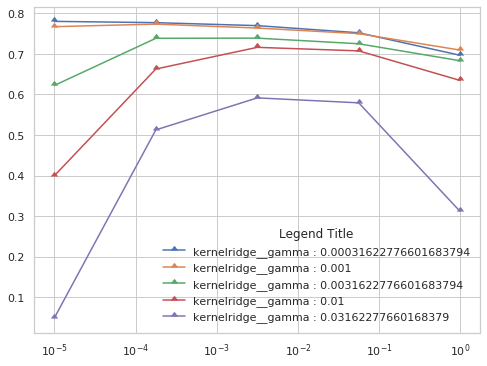

In [312]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


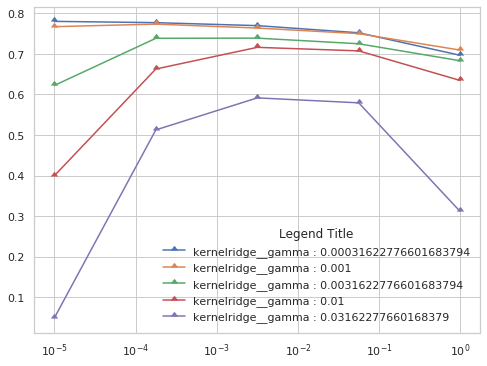

In [313]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


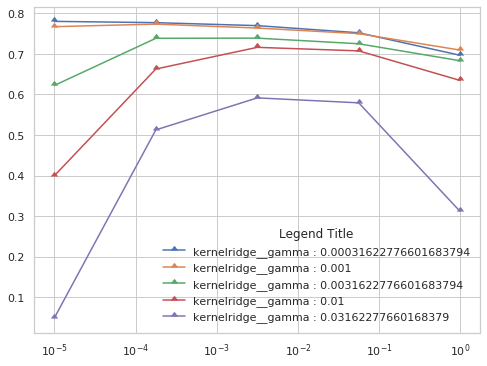

In [314]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [315]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [316]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026],
  [0.7800894925888603, -0.5579484990418468, -0.3678696581946731]]}

#### modele non linéaire : SVR

In [317]:
from sklearn.svm import SVR
model_ML = SVR()
                                     


In [318]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'SVR'

In [319]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [320]:



params = {
    "svr__C" : np.logspace(-1, 2, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 3)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [321]:
grid.cv_results_

{'mean_fit_time': array([1.83625689, 1.33745852, 1.30097799, 1.34046826, 1.31487312,
        1.32603607, 1.32883825, 1.37083907, 1.49261384, 1.40129495,
        1.62376986, 2.10829678, 1.49461355, 2.10499458, 4.72141399]),
 'std_fit_time': array([0.0333408 , 0.03037239, 0.007548  , 0.00503986, 0.00636087,
        0.01117719, 0.01141856, 0.01013793, 0.01756341, 0.01859283,
        0.14658835, 0.07435755, 0.00933273, 0.0403214 , 0.15889925]),
 'mean_score_time': array([0.24466829, 0.18440108, 0.17859836, 0.1862669 , 0.18258252,
        0.17781277, 0.18138413, 0.17594304, 0.16936193, 0.18122315,
        0.18433328, 0.16163445, 0.17653742, 0.16671672, 0.16012969]),
 'std_score_time': array([0.01395214, 0.00314524, 0.00245321, 0.00272209, 0.00040367,
        0.00222706, 0.00284729, 0.00112102, 0.00131883, 0.00821433,
        0.01176842, 0.00096573, 0.00057397, 0.00036937, 0.00110753]),
 'param_svr__C': masked_array(data=[0.1, 0.1, 0.1, 0.5623413251903491, 0.5623413251903491,
               

In [322]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [323]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5740011 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de RMSE est : -0.9776329 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de MAE est : -0.6931733 pour les paramètres svr__C : 100.0000000 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


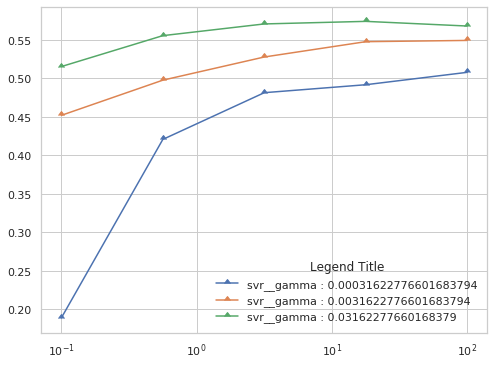

In [324]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


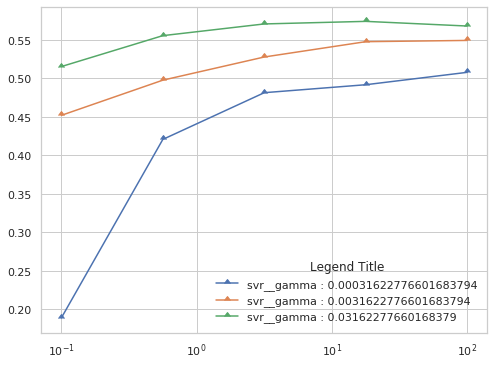

In [325]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


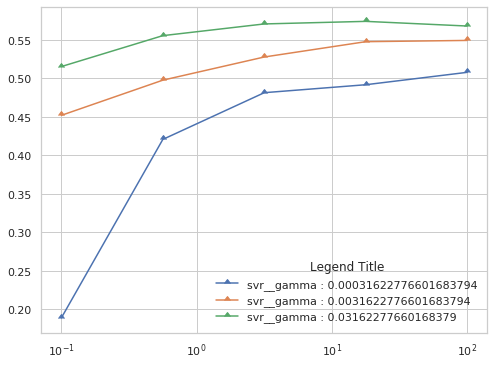

In [326]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [327]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [328]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487],
  [0.5857701588317937, -0.9642473010582634, -0.7157909663835565],
  [0.5740010568656239, -0.9776329004282809, -0.6931733497668366]]}

##### Consomation

In [329]:



params = {
    "svr__C" : np.logspace(-2, 3, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 5)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [330]:
grid.cv_results_

{'mean_fit_time': array([ 1.70960474,  1.34330087,  1.31820798,  1.26576738,  1.23057618,
         1.28631763,  1.20939412,  1.15101905,  1.139713  ,  1.15741887,
         1.16806507,  1.16523857,  1.18538222,  1.25333886,  1.383394  ,
         1.31458173,  1.46409807,  1.90213318,  2.74073858,  4.10701246,
         2.65913329,  5.22204785, 10.16221795, 21.94580851, 40.78035736]),
 'std_fit_time': array([0.24435271, 0.00305345, 0.01188441, 0.00265177, 0.00922739,
        0.00381396, 0.00539711, 0.00376742, 0.00717584, 0.01076744,
        0.00879399, 0.00427769, 0.01082059, 0.00295897, 0.01597752,
        0.03343033, 0.02235465, 0.07104491, 0.06379766, 0.03807871,
        0.07507656, 0.33368431, 0.33240032, 0.54537239, 2.09590388]),
 'mean_score_time': array([0.22562981, 0.18137717, 0.17784448, 0.17003298, 0.16709146,
        0.17188115, 0.15741057, 0.14993463, 0.14883142, 0.15034289,
        0.15156884, 0.15021572, 0.14867435, 0.14588718, 0.14422503,
        0.14834323, 0.14744239, 0.1

In [331]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [332]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7816481 pour les paramètres svr__C : 1000.0000000 et svr__gamma : 0.0031623

Le meilleur score de RMSE est : -0.5559407 pour les paramètres svr__C : 1000.0000000 et svr__gamma : 0.0031623

Le meilleur score de MAE est : -0.3573598 pour les paramètres svr__C : 3.1622777 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


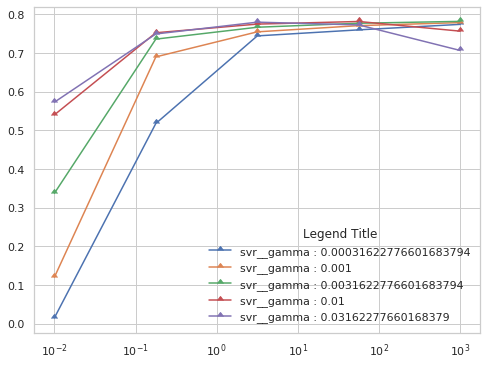

In [333]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


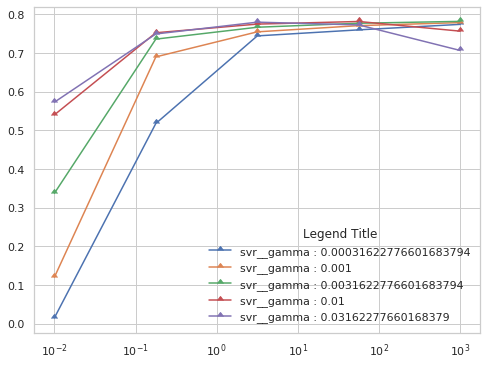

In [334]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


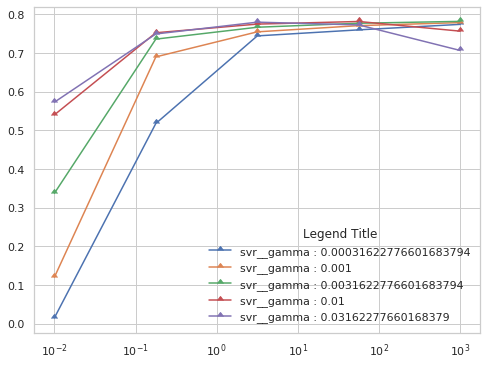

In [335]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [336]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [337]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026],
  [0.7800894925888603, -0.5579484990418468, -0.3678696581946731],
  [0.78164810309476, -0.5559406677431791, -0.3573597767765012]]}

#### modele non linéaire : réseau de neurones

In [338]:
from sklearn.neural_network import MLPRegressor

model_ML = MLPRegressor()

In [339]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'MLPRegressor'

In [340]:

model = make_pipeline(preprocessor,model_ML)
print(model.steps)


[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                  'logGFABuild']),
                                ('pipeline-2',
                                 Pipel...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  'U

In [341]:



params = {
    'mlpregressor__max_iter': [50, 100,200],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['identity'],
    'mlpregressor__solver': ["lbfgs"],
    'mlpregressor__learning_rate_init' : np.logspace(-4, -1, 4)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [342]:
grid.cv_results_

{'mean_fit_time': array([0.06336427, 0.08059769, 0.07411356, 0.0826859 , 0.07857461,
        0.08585172, 0.08017521, 0.07947083, 0.08068352, 0.08367491,
        0.08392215, 0.08548789, 0.14592752, 0.16028361, 0.15790448,
        0.15241575, 0.15488148, 0.15396481, 0.13789411, 0.11441317,
        0.10999737, 0.12038255, 0.11540189, 0.11317596, 0.1681397 ,
        0.16964703, 0.18716159, 0.19369698, 0.18947692, 0.16641374,
        0.18938122, 0.22039304, 0.19456391, 0.18797565, 0.18638539,
        0.20678205]),
 'std_fit_time': array([0.00529547, 0.00962711, 0.0079725 , 0.01016198, 0.00617818,
        0.00429576, 0.006716  , 0.00776714, 0.00755131, 0.00748751,
        0.01364181, 0.00355924, 0.02740713, 0.01866061, 0.01187206,
        0.01482243, 0.01456257, 0.01265562, 0.01989449, 0.00566166,
        0.00642531, 0.00879931, 0.00879004, 0.00443395, 0.01610677,
        0.01000543, 0.00441807, 0.01222807, 0.02544703, 0.0189785 ,
        0.00821486, 0.05064868, 0.01510201, 0.01672406, 0.027

In [343]:
paramList = list(params.keys())
np.shape(paramList)[0]

5

In [344]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5112933 pour les paramètres mlpregressor__max_iter : 50.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de RMSE est : -1.0465676 pour les paramètres mlpregressor__max_iter : 50.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de MAE est : -0.8353297 pour les paramètres mlpregressor__max_iter : 50.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


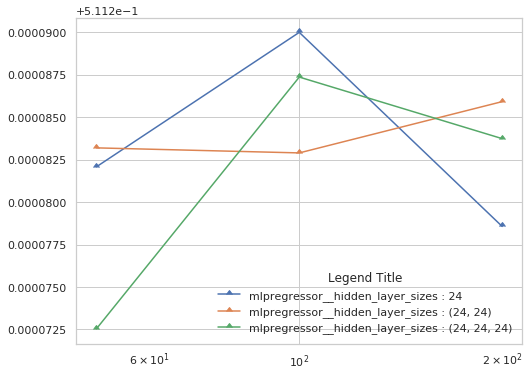

In [345]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


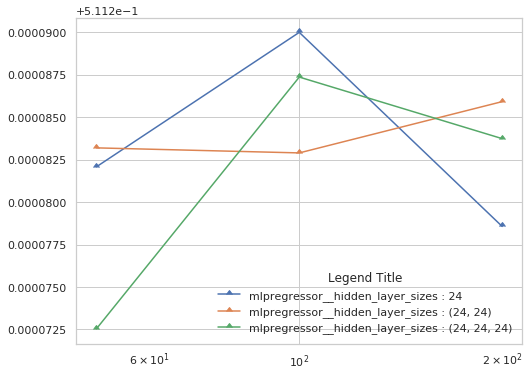

In [346]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


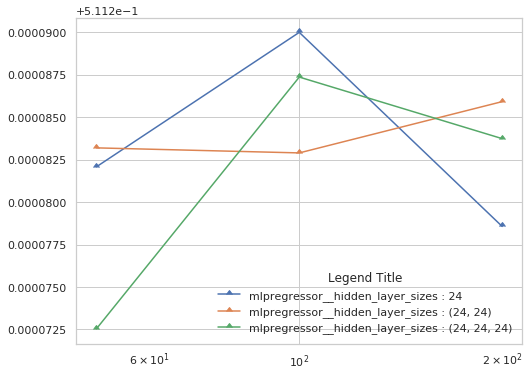

In [347]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [348]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [349]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487],
  [0.5857701588317937, -0.9642473010582634, -0.7157909663835565],
  [0.5740010568656239, -0.9776329004282809, -0.6931733497668366],
  [0.5112932574051914, -1.0465676368720058, -0.8353296910598875]]}

##### Consomation

In [350]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [351]:
grid.cv_results_

{'mean_fit_time': array([0.36359606, 0.61468601, 0.65991597, 0.72245975, 0.97759743,
        1.53200397, 0.5109313 , 0.79158931, 1.00936756, 1.41379085,
        1.82968936, 2.72601805, 0.73665686, 1.15197554, 1.45923028,
        2.13800044, 2.79664817, 4.12915459]),
 'std_fit_time': array([0.01599831, 0.01392699, 0.12306793, 0.03563553, 0.03991836,
        0.14926016, 0.01431755, 0.03509876, 0.05758108, 0.03484232,
        0.03337644, 0.0312127 , 0.01708443, 0.02224668, 0.02782874,
        0.06546543, 0.05641404, 0.09465422]),
 'mean_score_time': array([0.01075959, 0.01065454, 0.00948052, 0.00909886, 0.00759444,
        0.00797472, 0.00985746, 0.00928192, 0.00862231, 0.00875993,
        0.00834985, 0.00880942, 0.00961313, 0.00945024, 0.00944109,
        0.00941486, 0.00924234, 0.00910716]),
 'std_score_time': array([0.0009149 , 0.00038131, 0.00146606, 0.0025978 , 0.00016145,
        0.00042619, 0.00225325, 0.00174473, 0.00021111, 0.00053371,
        0.00019004, 0.0002326 , 0.00019485, 

In [352]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [353]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]
    
    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7783020 pour les paramètres mlpregressor__max_iter : 200.0000000 et mlpregressor__hidden_layer_sizes : 24

Le meilleur score de RMSE est : -0.5602172 pour les paramètres mlpregressor__max_iter : 200.0000000 et mlpregressor__hidden_layer_sizes : 24

Le meilleur score de MAE est : -0.3744970 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : 24


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


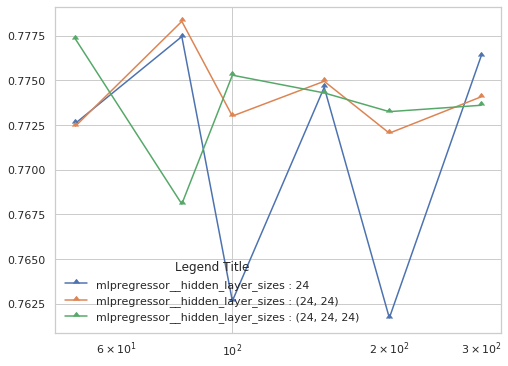

In [354]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


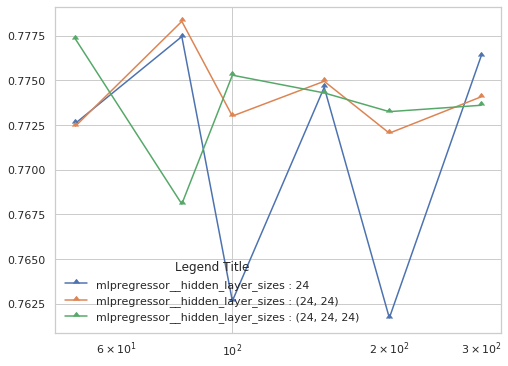

In [355]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


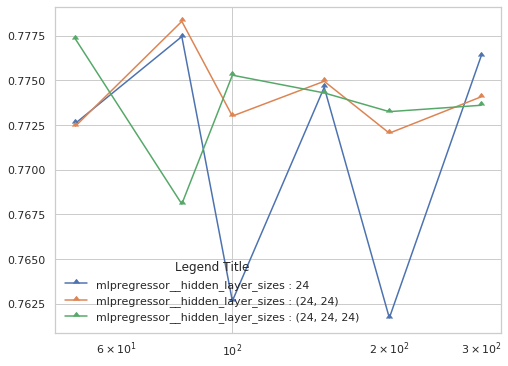

In [356]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [357]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [358]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026],
  [0.7800894925888603, -0.5579484990418468, -0.3678696581946731],
  [0.78164810309476, -0.5559406677431791, -0.3573597767765012],
  [0.7783020115784125, -0.5602172475751619, -0.37449698299910894]]}

#### forêts aléatoires

In [981]:
from sklearn.ensemble import RandomForestRegressor
model_ML = RandomForestRegressor()

In [982]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

In [983]:
model = make_pipeline(preprocessor,model_ML)
print(model.steps)

[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                  'logGFABuild']),
                                ('pipeline-2',
                                 Pipel...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  'U

###### test des param pour nb arbre = 100.              'max_depth': [10,20,50,70], 'min_samples_leaf': (1, 5, 10),  max_features': (5, 10, 20)

In [984]:
RF_ERROR_EMI_noStar = {    
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
RF_ERROR_CONSO_noStar = {  
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

In [985]:




# evaluation : __max_depth
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar






time 26.34s


In [364]:
# evaluation : __min_samples_leaf
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar





{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.756587243893563, -0.7391418631180608, -0.5107026821128897],
  [0.757148303227541, -0.7381980933401693, -0.5101742024597634]]}

In [365]:
# evaluation : __max_features
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar

{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)],
  ['randomforestregressor__max_features', (5, 10, 15)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.756587243893563, -0.7391418631180608, -0.5107026821128897],
  [0.757148303227541, -0.7381980933401693, -0.5101742024597634],
  [0.7606626431362283, -0.7331471615797609, -0.5060743657377499]]}

In [366]:
print(params[paramList[1]])

(5, 10, 15)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

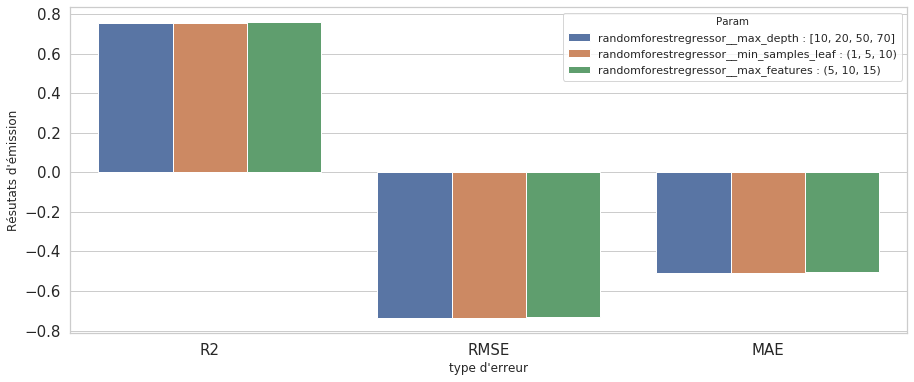

In [367]:
result = []
param = []
for k in range(3) : 
    for l in range(3) : 
        result.append(RF_ERROR_EMI_noStar["Resuts"][k][l])
        param.append(RF_ERROR_EMI_noStar["Param"][k][0] + " : " + str(RF_ERROR_EMI_noStar["Param"][k][1]))
d = {
    'Param' : param,
    "type d'erreur" : RF_ERROR_EMI_noStar["type d'erreur"]*3,
    "Résutats d'émission": result}

RF_resultatEMI_noStar= pd.DataFrame(data=d)

fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = RF_resultatEMI_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Param", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [368]:
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 15), 
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [369]:
grid.cv_results_

{'mean_fit_time': array([0.50068402, 0.37846761, 0.32337818, 0.56724262, 0.52067957,
        0.4874279 , 0.75323491, 0.69249434, 0.65412393, 0.59077663,
        0.37900658, 0.33736014, 0.87812266, 0.59930806, 0.52184677,
        1.16044917, 0.79992518, 0.68997102, 0.63750052, 0.37653651,
        0.33703847, 0.9110827 , 0.59670329, 0.52475295, 1.19353108,
        0.79816804, 0.68878345, 0.63336644, 0.37782745, 0.33604555,
        0.90976362, 0.59958363, 0.52010846, 1.19401145, 0.79512916,
        0.69398127]),
 'std_fit_time': array([0.01848736, 0.02752784, 0.00351211, 0.00552998, 0.00492307,
        0.00199832, 0.00205328, 0.00295776, 0.00466956, 0.00246117,
        0.0037451 , 0.00268732, 0.00715358, 0.00259153, 0.00179157,
        0.00484299, 0.00391571, 0.00447825, 0.00292695, 0.00462379,
        0.00228516, 0.00398643, 0.00455487, 0.0025288 , 0.00590385,
        0.00413344, 0.00303258, 0.00392872, 0.00283039, 0.00337555,
        0.00392549, 0.00249189, 0.00284892, 0.00832895, 0.005

In [370]:
resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

print("\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(resultR2,resultRMSE, resultMAE) )


ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])


resultR2 : 0.762610643385653 
resultRMSE  : -0.7300626074994433 
resultMAE : -0.5057168428077689 



In [371]:
RF_resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
RF_resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
RF_resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

In [372]:
RF_resultR2

0.762610643385653

###### selection features

In [986]:
import timeit

start_time = timeit.default_timer()

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)


elapsed = timeit.default_timer() - start_time

print("time {:.2f}s".format(elapsed))

time 3.78s


In [374]:
                                                    
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}                                                                                
                                                                                     
reg = RandomForestRegressor(max_depth=40,                                            
                    n_estimators=100,                                                
                    min_samples_leaf=1,                                                
                    max_features=10)                                                       
reg.fit(X_train_noStar, Y_train_noStarEMI)                                                                         
# pipe = make_pipeline(model, SelectFromModel(reg), clone(reg))                    
                                                                                     
# gs_pipe = GridSearchCV(pipe, param, cv=5, scoring="r2")                               
# gs_pipe.fit(X_train_noStar, Y_train_noStarEMI) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 5 (0.436967)
2. feature 1 (0.171680)
3. feature 3 (0.080357)
4. feature 16 (0.068794)
5. feature 0 (0.044762)
6. feature 4 (0.035271)
7. feature 8 (0.032370)
8. feature 10 (0.027517)
9. feature 9 (0.019201)
10. feature 12 (0.014711)
11. feature 14 (0.010871)
12. feature 13 (0.009496)
13. feature 18 (0.008997)
14. feature 2 (0.008602)
15. feature 11 (0.007789)
16. feature 17 (0.006739)
17. feature 6 (0.006327)
18. feature 19 (0.003962)
19. feature 7 (0.002725)
20. feature 20 (0.001470)
21. feature 15 (0.001394)


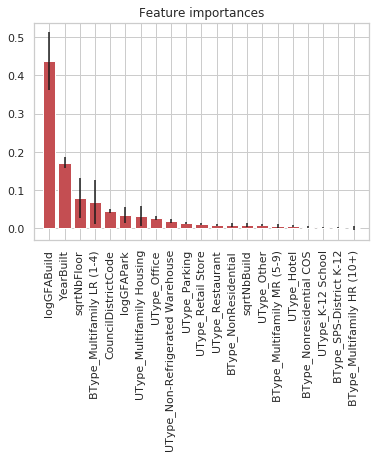

In [375]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_noStar.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_noStar.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_noStar.shape[1]), X_train_noStar.columns[indices])
plt.xlim([-1, X_train_noStar.shape[1]])
plt.xticks(rotation=90)
plt.show()

##### Consomation

###### test des param pour nb arbre = 100.              'max_depth': [10,20,50,70], 'min_samples_leaf': (1, 5, 10),  max_features': (5, 10, 20)

In [376]:
RF_ERROR_CONSO_noStar = {    
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
RF_ERROR_CONSO_noStar = {  
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

In [377]:
# evaluation : __max_depth
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar




{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8597679832527975, -0.4452290866200007, -0.2757478106506296]]}

In [378]:
# evaluation : __min_samples_leaf
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar





{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8597679832527975, -0.4452290866200007, -0.2757478106506296],
  [0.8605120565371076, -0.4439812147583586, -0.2760408172980864]]}

In [379]:
# evaluation : __max_features
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar

{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)],
  ['randomforestregressor__max_features', (5, 10, 15)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8597679832527975, -0.4452290866200007, -0.2757478106506296],
  [0.8605120565371076, -0.4439812147583586, -0.2760408172980864],
  [0.864478802891002, -0.43773367012231096, -0.27009928408018175]]}

In [380]:
print(params[paramList[1]])

(5, 10, 15)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

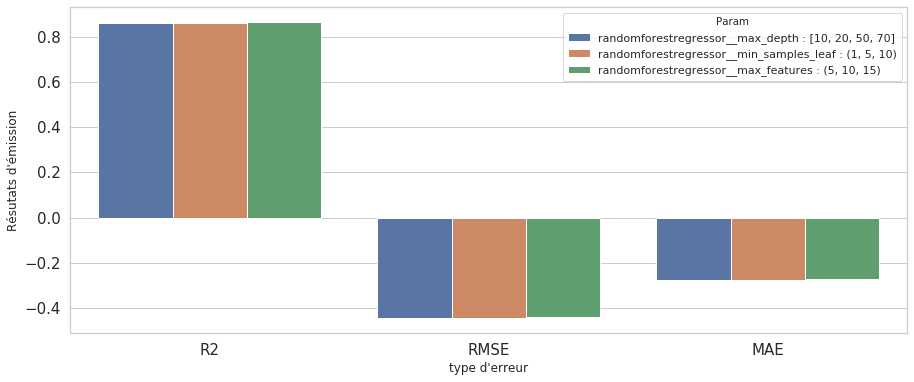

In [381]:
result = []
param = []
for k in range(3) : 
    for l in range(3) : 
        result.append(RF_ERROR_CONSO_noStar["Resuts"][k][l])
        param.append(RF_ERROR_CONSO_noStar["Param"][k][0] + " : " + str(RF_ERROR_CONSO_noStar["Param"][k][1]))
d = {
    'Param' : param,
    "type d'erreur" : RF_ERROR_CONSO_noStar["type d'erreur"]*3,
    "Résutats d'émission": result}

RF_resultatCONSO_noStar= pd.DataFrame(data=d)

fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = RF_resultatCONSO_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Param", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [382]:
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [40,50,60],
            'randomforestregressor__min_samples_leaf': (1, 5),   
            'randomforestregressor__max_features': (5, 10, 15),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [383]:
resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

###### selection features

In [384]:
from sklearn.feature_selection import SelectFromModel

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}                                                                                
                                                                                     
reg = RandomForestRegressor(max_depth=40,                                            
                    n_estimators=100,                                                
                    min_samples_leaf=1,                                                
                    max_features=10)                                                       
reg.fit(X_train_noStar, Y_train_noStarCONSO)                                                                         


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 5 (0.550511)
2. feature 4 (0.128325)
3. feature 3 (0.082089)
4. feature 1 (0.065103)
5. feature 0 (0.023884)
6. feature 16 (0.021943)
7. feature 8 (0.020312)
8. feature 9 (0.019970)
9. feature 18 (0.016069)
10. feature 10 (0.015150)
11. feature 12 (0.012595)
12. feature 11 (0.008123)
13. feature 17 (0.007124)
14. feature 14 (0.006782)
15. feature 13 (0.005778)
16. feature 2 (0.005611)
17. feature 19 (0.003910)
18. feature 7 (0.003320)
19. feature 6 (0.001443)
20. feature 15 (0.001264)
21. feature 20 (0.000694)


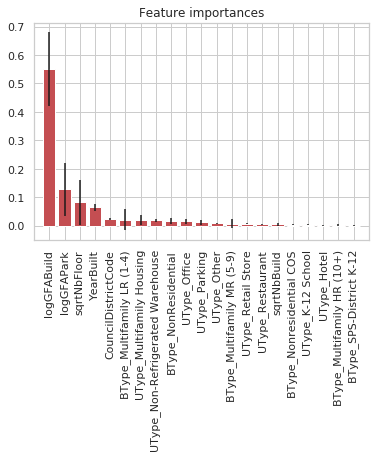

In [385]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_noStar.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_noStar.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_noStar.shape[1]), X_train_noStar.columns[indices])
plt.xlim([-1, X_train_noStar.shape[1]])
plt.xticks(rotation=90)
plt.show()

#### Gradient Boosting

In [989]:

from sklearn.ensemble import GradientBoostingRegressor
model_ML = GradientBoostingRegressor()

In [990]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'GradientBoostingRegressor'

In [991]:
model = make_pipeline(preprocessor,model_ML)
model.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('pipeline-1',
                                   Pipeline(memory=None,
                                            steps=[('standardscaler',
                                                    StandardScaler(copy=True,
                                                                   with_mean=True,
                                                                   with_std=True))],
                                            verbose=False),
                                   ['CouncilDistrictCode', 'YearBuilt',
                                    'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                    'logGFABuild']),
                                  ('pipeline-2',
                                   Pipel...
                                   ['UType_Hotel', 'UType_K-12 School',
      

In [992]:



params = {
            'gradientboostingregressor__n_estimators': (100, 500, 800),
            'gradientboostingregressor__learning_rate': np.logspace(-3, 0, 5),    
            'gradientboostingregressor__max_depth': (3, 5),      
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [993]:
grid.cv_results_

{'mean_fit_time': array([0.36306319, 2.15815902, 5.52292805, 0.93495293, 3.80891414,
        5.95320625, 0.47693582, 2.33536415, 3.72850552, 0.75130706,
        3.84004602, 8.0333745 , 0.48520679, 2.36067672, 3.69166827,
        0.74664888, 3.69517484, 5.91688838, 0.47148442, 2.31363192,
        3.68294358, 0.74702826, 3.69246974, 5.91812267, 0.46998324,
        2.30498977, 3.69724283, 0.74731078, 3.79580941, 5.92669344]),
 'std_fit_time': array([0.02507808, 0.60124111, 1.48113117, 0.17384134, 0.10870113,
        0.04313961, 0.00690362, 0.01190491, 0.01094812, 0.00425326,
        0.2590841 , 2.18855054, 0.03161469, 0.10927372, 0.0107633 ,
        0.00651699, 0.01342691, 0.02819931, 0.00474326, 0.00672034,
        0.00344777, 0.00977447, 0.01718112, 0.04127896, 0.00669689,
        0.00572297, 0.0090885 , 0.00839776, 0.08489645, 0.02945562]),
 'mean_score_time': array([0.00494905, 0.01421213, 0.03578458, 0.00987492, 0.02158709,
        0.03179531, 0.00666046, 0.01465464, 0.02012911, 0.00

In [390]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [391]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7536055 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de RMSE est : -0.7429047 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de MAE est : -0.4720319 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279


In [392]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [393]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487],
  [0.5857701588317937, -0.9642473010582634, -0.7157909663835565],
  [0.5740010568656239, -0.9776329004282809, -0.6931733497668366],
  [0.5112932574051914, -1.0465676368720058, -0.8353296910598875],
  [0.762610643385653, -0.7300626074994433, -0.5057168428077689],
  [0.7536055477261886, -0.742904712343291, -0.4720319245735258]]}

In [ ]:
import timeit

start_time = timeit.default_timer()



params = {
            'gradientboostingregressor__n_estimators': ([800]),
            'gradientboostingregressor__learning_rate': ([0.1778279]),    
            'gradientboostingregressor__max_depth': (3, 5),      
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)


elapsed = timeit.default_timer() - start_time

print("time {:.2f}s".format(elapsed))

In [394]:
paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
bestParam 

{'gradientboostingregressor__learning_rate': 0.1778279410038923,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__n_estimators': 800}

##### Consomation

In [395]:



params = {
            'gradientboostingregressor__n_estimators': (100, 200, 400),
            'gradientboostingregressor__learning_rate': np.logspace(-2, -1, 3),    
            'gradientboostingregressor__max_depth': (3, 5),      
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [396]:
grid.cv_results_

{'mean_fit_time': array([0.62354703, 1.01484685, 1.80405812, 0.73787274, 1.46144886,
        2.88901553, 0.46198521, 0.90571885, 1.8033711 , 0.73014097,
        1.44721031, 2.88204837, 0.45631194, 0.9034719 , 1.79525733,
        0.72606053, 1.45233159, 2.86529236]),
 'std_fit_time': array([0.02934994, 0.13614928, 0.01240971, 0.00532054, 0.00638574,
        0.00838253, 0.00744931, 0.00412546, 0.00828402, 0.00592694,
        0.00467035, 0.01205249, 0.00620258, 0.0046165 , 0.00612108,
        0.0092491 , 0.01569083, 0.00532035]),
 'mean_score_time': array([0.00869894, 0.00873876, 0.01146622, 0.00775633, 0.0107729 ,
        0.01622515, 0.00632095, 0.00773001, 0.0102478 , 0.00752754,
        0.00992308, 0.01393723, 0.00590439, 0.00717349, 0.00956106,
        0.00697699, 0.00908098, 0.01285429]),
 'std_score_time': array([0.00023567, 0.00071759, 0.00011812, 0.00014022, 0.00015919,
        0.00024323, 0.00011579, 0.00014875, 0.00015552, 0.0001297 ,
        0.00019762, 0.00021626, 0.00011744, 

In [397]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [398]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8499143 pour les paramètres gradientboostingregressor__n_estimators : 400.0000000 et gradientboostingregressor__learning_rate : 0.1000000

Le meilleur score de RMSE est : -0.4609845 pour les paramètres gradientboostingregressor__n_estimators : 400.0000000 et gradientboostingregressor__learning_rate : 0.1000000

Le meilleur score de MAE est : -0.3009398 pour les paramètres gradientboostingregressor__n_estimators : 400.0000000 et gradientboostingregressor__learning_rate : 0.1000000


In [399]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [400]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026],
  [0.7800894925888603, -0.5579484990418468, -0.3678696581946731],
  [0.78164810309476, -0.5559406677431791, -0.3573597767765012],
  [0.7783020115784125, -0.5602172475751619, -0.37449698299910894],
  [0.8657686200195907, -0.43556350091554535, -0.2685986737462134],
  [0.849914284213332, -0.4609845072872133, -0.30093976623873575]]}

In [401]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=X_train_noStar,label=Y_train_noStarCONSO)

In [402]:
# model_ML = xgb.XGBRegressor()

In [403]:
# import re
# model_name = re.search("(^\w*)", str(model_ML)).group(0)
# model_name

In [404]:
# model = make_pipeline(preprocessor,model_ML)
# model.steps

In [405]:
# params = {
#             'xgbregressor__n_estimators': (100, 500, 1000),
# #             'xgbregressor__learning_rate': np.logspace(-3, 0, 5),    
# #             'xgbregressor__gamma': np.logspace(0, 3, 4),    
# }

# grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
# grid.fit(X_train,y_trainEMI)

In [406]:
# paramList = list(params.keys())
# result = grid.cv_results_['mean_test_r2']
# bestScore = np.amax(result)
# resultID = np.where(result == np.amax(result))
# bestParam = grid.cv_results_["params"][resultID[0][0]]
# print(bestParam)

# resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
# resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
# resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])
# print("\nXGBoost :\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(resultR2,resultRMSE, resultMAE) )


# print("\nRandom forest :\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(RF_resultR2,RF_resultRMSE, RF_resultMAE) )


### Résultats

#### Emission

In [407]:
# del ERROR_CONSO_noStar['Modèle'][7:]
# del ERROR_CONSO_noStar['Resuts'][7:]
# ERROR_CONSO_noStar
# del ERROR_EMI_noStar['Modèle'][7:]
# del ERROR_EMI_noStar['Resuts'][7:]
# ERROR_EMI_noStar

In [408]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5112830654895999, -1.0465787950593721, -0.8353441114494607],
  [0.511320389217664, -1.0465413179950285, -0.835335301807753],
  [0.578574807907384, -0.9723148163322384, -0.6876534291733807],
  [0.5684945216517373, -0.9840201893376163, -0.5705275483728487],
  [0.5857701588317937, -0.9642473010582634, -0.7157909663835565],
  [0.5740010568656239, -0.9776329004282809, -0.6931733497668366],
  [0.5112932574051914, -1.0465676368720058, -0.8353296910598875],
  [0.762610643385653, -0.7300626074994433, -0.5057168428077689],
  [0.7536055477261886, -0.742904712343291, -0.4720319245735258]]}

In [409]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(abs(ERROR_EMI_noStar["Resuts"][k][l]))
        model.append(ERROR_EMI_noStar["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_EMI_noStar["type d'erreur"]*np.shape(ERROR_EMI_noStar["Modèle"])[0],
    "Résutats d'émission": result}


In [410]:
d

{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 "Résutats d'émission": [0.5112830654895999,
  1.0465787950593721,
  0.8353441114494607,
  0.511320389217664,
  1.0465413179950285,
  0.835335301807753,
  0.578574807907384,
  0.9723148163322384,
 

In [411]:
resultatEMI_noStar= pd.DataFrame(data=d)
resultatEMI_noStar

Modèle type d'erreur  Résutats d'émission
0            LinearRegression            R2             0.511283
1            LinearRegression          RMSE             1.046579
2            LinearRegression           MAE             0.835344
3                  ElasticNet            R2             0.511320
4                  ElasticNet          RMSE             1.046541
5                  ElasticNet           MAE             0.835335
6                      SVRlin            R2             0.578575
7                      SVRlin          RMSE             0.972315
8                      SVRlin           MAE             0.687653
9         KNeighborsRegressor            R2             0.568495
10        KNeighborsRegressor          RMSE             0.984020
11        KNeighborsRegressor           MAE             0.570528
12                KernelRidge            R2             0.585770
13                KernelRidge          RMSE             0.964247
14                KernelRidge           MAE             0.715791
15                        SVR            R2             0.574001
16                        SVR          RMSE             0.977633
17                        SVR           MAE             0.693173
18               MLPRegressor            R2             0.511293
19               MLPRegressor          RMSE             1.046568
20               MLPRegressor           MAE             0.835330
21      RandomForestRegressor            R2             0.762611
22      RandomForestRegressor          RMSE             0.730063
23      RandomForestRegressor           MAE             0.505717
24  GradientBoostingRegressor            R2             0.753606
25  GradientBoostingRegressor          RMSE             0.742905
26  GradientBoostingRegressor           MAE             0.472032

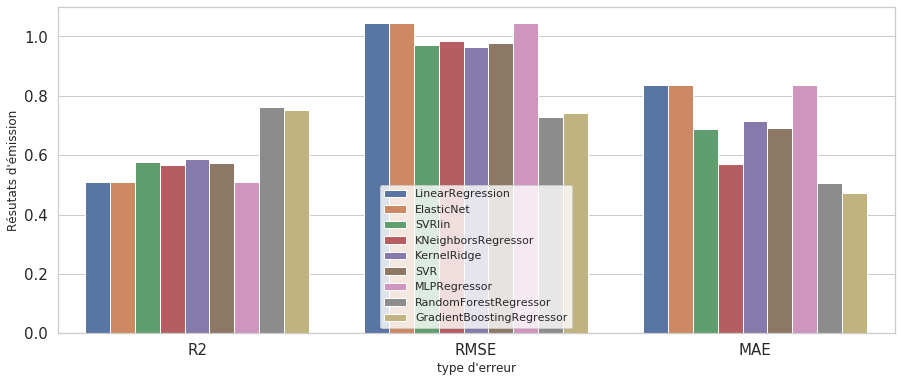

In [412]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatEMI_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.legend(loc='lower center')

#### Consomation

In [413]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7515791052866306, -0.5928531422735992, -0.39996472232144126],
  [0.7515895909504021, -0.5928390242930149, -0.39974637227681875],
  [0.778813102679119, -0.5597399796794088, -0.35600649177232124],
  [0.7388519201504827, -0.6081199026841695, -0.32505293159180026],
  [0.7800894925888603, -0.5579484990418468, -0.3678696581946731],
  [0.78164810309476, -0.5559406677431791, -0.3573597767765012],
  [0.7783020115784125, -0.5602172475751619, -0.37449698299910894],
  [0.8657686200195907, -0.43556350091554535, -0.2685986737462134],
  [0.849914284213332, -0.4609845072872133, -0.30093976623873575]]}

In [414]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(abs(ERROR_CONSO_noStar["Resuts"][k][l]))
        model.append(ERROR_CONSO_noStar["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_CONSO_noStar["type d'erreur"]*np.shape(ERROR_CONSO_noStar["Modèle"])[0],
    "Résutats de consomation": result
}
d


{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 'Résutats de consomation': [0.7515791052866306,
  0.5928531422735992,
  0.39996472232144126,
  0.7515895909504021,
  0.5928390242930149,
  0.39974637227681875,
  0.778813102679119,
  0.55973997967

In [415]:
resultatCONSO_noStar= pd.DataFrame(data=d)
resultatCONSO_noStar

Modèle type d'erreur  Résutats de consomation
0            LinearRegression            R2                 0.751579
1            LinearRegression          RMSE                 0.592853
2            LinearRegression           MAE                 0.399965
3                  ElasticNet            R2                 0.751590
4                  ElasticNet          RMSE                 0.592839
5                  ElasticNet           MAE                 0.399746
6                      SVRlin            R2                 0.778813
7                      SVRlin          RMSE                 0.559740
8                      SVRlin           MAE                 0.356006
9         KNeighborsRegressor            R2                 0.738852
10        KNeighborsRegressor          RMSE                 0.608120
11        KNeighborsRegressor           MAE                 0.325053
12                KernelRidge            R2                 0.780089
13                KernelRidge          RMSE                 0.557948
14                KernelRidge           MAE                 0.367870
15                        SVR            R2                 0.781648
16                        SVR          RMSE                 0.555941
17                        SVR           MAE                 0.357360
18               MLPRegressor            R2                 0.778302
19               MLPRegressor          RMSE                 0.560217
20               MLPRegressor           MAE                 0.374497
21      RandomForestRegressor            R2                 0.865769
22      RandomForestRegressor          RMSE                 0.435564
23      RandomForestRegressor           MAE                 0.268599
24  GradientBoostingRegressor            R2                 0.849914
25  GradientBoostingRegressor          RMSE                 0.460985
26  GradientBoostingRegressor           MAE                 0.300940

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

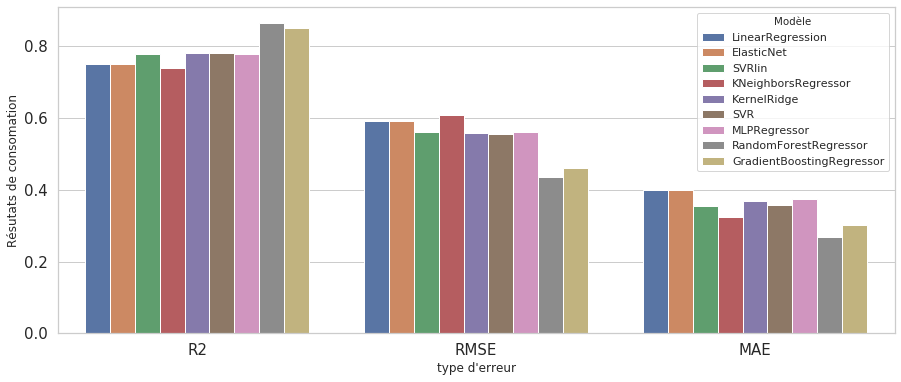

In [416]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatCONSO_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#### Save result noStar

In [417]:
resultatEMI_noStar.to_csv('resultatEMI_noStar.csv', sep='\t', encoding='utf-8')
resultatCONSO_noStar.to_csv('resultatCONSO_noStar.csv', sep='\t', encoding='utf-8')


# Algorithme de descente de sélection de variables 

In [900]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()


data = pd.read_csv('donneeIngFeaturing.csv', sep='\t')
targetEMI = "logEMI"
targetCONSO = "logCONSO"

In [901]:

data = data.drop(columns = ["Unnamed: 0", "Unnamed: 1"])
dataStar = data.dropna()
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [902]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()

resultatEMI = pd.read_csv('resultatEMI.csv', sep='\t')
resultatCONSO = pd.read_csv('resultatCONSO.csv', sep='\t')


resultatEMI_noStar = pd.read_csv('resultatEMI_noStar.csv', sep='\t')
resultatCONSO_noStar = pd.read_csv('resultatCONSO_noStar.csv', sep='\t')

resultatEMI=resultatEMI.drop(columns="Unnamed: 0")
resultatCONSO=resultatCONSO.drop(columns="Unnamed: 0")
resultatEMI_noStar=resultatEMI_noStar.drop(columns="Unnamed: 0")
resultatCONSO_noStar=resultatCONSO_noStar.drop(columns="Unnamed: 0")

In [903]:
X_train_noStar = pd.read_csv('X_train_noStar.csv', sep='\t')

Y_train_noStar = pd.read_csv('Y_train_noStar.csv', sep='\t')


X_test_noStar = pd.read_csv('X_test_noStar.csv', sep='\t')

Y_test_noStar = pd.read_csv('Y_test_noStar.csv', sep='\t')


X_train_noStar=X_train_noStar.drop(columns="Unnamed: 0")
Y_train_noStar=Y_train_noStar.drop(columns="Unnamed: 0")
X_test_noStar=X_test_noStar.drop(columns="Unnamed: 0")
Y_test_noStar=Y_test_noStar.drop(columns="Unnamed: 0")

Y_train_noStarCONSO = Y_train_noStar["logCONSO"]
Y_train_noStarEMI = Y_train_noStar["logEMI"]

print(Y_train_noStarCONSO.shape)
print(Y_train_noStarEMI.shape)

(5212,)
(5212,)


In [904]:
print( "X Train {} et Y Train {} \n".format(X_train_noStar.shape,np.shape(Y_train_noStarEMI))  )

print( "CONSO X Train {} et Y Train {} \n".format(X_train_noStar.shape,np.shape(Y_train_noStarCONSO))  )

print( "X Test {} et Y Test{} \n".format(X_test_noStar.shape,np.shape(Y_test_noStar))  )

X Train (5212, 21) et Y Train (5212,) 

CONSO X Train (5212, 21) et Y Train (5212,) 

X Test (1303, 21) et Y Test(1303, 2) 



__Choix du modèle de forêt aléatoire !__

## Choix du jeu de donnée avec ou sans ENERGY STAR

In [905]:
bestEmi = resultatEMI.loc[resultatEMI['Modèle']  == "RandomForestRegressor"]
bestEmi_noStar = resultatEMI_noStar.loc[resultatEMI_noStar['Modèle']  == "RandomForestRegressor"]

In [906]:
for index,i in bestEmi.iterrows() : 
    bestEmi.loc[index,"Résutats d'émission"] = abs(bestEmi.loc[index,"Résutats d'émission"])
bestEmi
    

/home/ious/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Modèle type d'erreur  Résutats d'émission
21  RandomForestRegressor            R2             0.772446
22  RandomForestRegressor          RMSE             0.697218
23  RandomForestRegressor           MAE             0.499638

In [907]:
bestEmi_noStar

Modèle type d'erreur  Résutats d'émission
21  RandomForestRegressor            R2             0.762611
22  RandomForestRegressor          RMSE             0.730063
23  RandomForestRegressor           MAE             0.505717

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

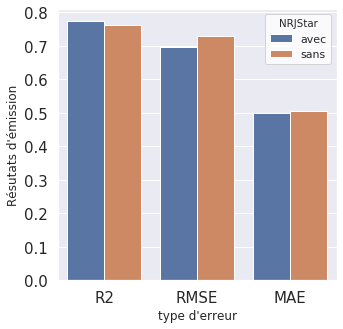

In [908]:
diffEMI_Star = bestEmi.copy()
diffEMI_Star["NRJStar"] = "avec"
diffEMI_Star["type d'erreur"] = bestEmi["type d'erreur"] 

diffEMI_noStar = bestEmi_noStar.copy()
diffEMI_noStar["NRJStar"] = "sans"
diffEMI_noStar["type d'erreur"] = bestEmi["type d'erreur"] 

diffEMI = pd.concat([diffEMI_Star, diffEMI_noStar])
diffEMI
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="NRJStar", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [909]:
bestCONSO = resultatCONSO.loc[resultatCONSO['Modèle']  == "RandomForestRegressor"]
bestCONSO_noStar = resultatCONSO_noStar.loc[resultatCONSO_noStar['Modèle']  == "RandomForestRegressor"]
bestCONSO_noStar

Modèle type d'erreur  Résutats de consomation
21  RandomForestRegressor            R2                 0.865769
22  RandomForestRegressor          RMSE                 0.435564
23  RandomForestRegressor           MAE                 0.268599

In [910]:
for index,i in bestCONSO.iterrows() : 
    bestCONSO.loc[index,"Résutats de consomation"] = abs(bestCONSO.loc[index,"Résutats de consomation"])
bestCONSO

Modèle type d'erreur  Résutats de consomation
21  RandomForestRegressor            R2                 0.921050
22  RandomForestRegressor          RMSE                 0.323467
23  RandomForestRegressor           MAE                 0.189430

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

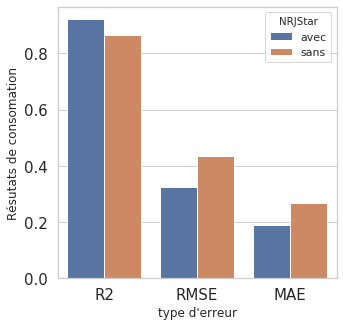

In [911]:
diffCONSO_Star = bestCONSO.copy()
diffCONSO_Star["NRJStar"] = "avec"
diffCONSO_Star["type d'erreur"] = bestCONSO["type d'erreur"] 

diffCONSO_noStar = bestCONSO_noStar.copy()
diffCONSO_noStar["NRJStar"] = "sans"
diffCONSO_noStar["type d'erreur"] = bestCONSO["type d'erreur"] 

diffCONSO = pd.concat([diffCONSO_Star, diffCONSO_noStar])
diffCONSO

fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="NRJStar", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

__Choix de faire l'étude sans ENERGY STAR__

## Evaluation sur valeurs réelles de l'erreur sur le jeu test

In [912]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [913]:

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'logGFAPark', 'logGFABuild']

categorical_features = dataNoStar.columns[15:].to_list()


In [914]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

In [915]:
from sklearn.ensemble import RandomForestRegressor

ERROR = {'EMI': [], 'CONSO': []}

model_ML = RandomForestRegressor()

model_name = re.search("(^\w*)", str(model_ML)).group(0)

model = make_pipeline(preprocessor,model_ML)


### Emission

In [916]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS



In [917]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

##### Emission

In [918]:

score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

In [919]:
params = {
        'randomforestregressor__n_estimators': [100],    
        'randomforestregressor__max_depth': [40],
        'randomforestregressor__min_samples_leaf': [1],   
        'randomforestregressor__max_features': [10],   
}

# score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

#### erreur sur log emi

In [920]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logEMI"]
y_pred = grid.predict(X_test_noStar)
err = r2_score(y_true, y_pred)
ERROR["EMI"].append(err)

In [921]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["EMI"].append(err)

In [922]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["EMI"].append(err)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

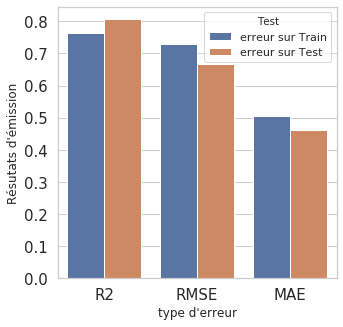

In [923]:
diffEMI_Train = bestEmi_noStar.copy()
diffEMI_Train["Test"] = "erreur sur Train"

diffEMI_True = bestEmi_noStar.copy()
diffEMI_True["Test"] = "erreur sur Test"
diffEMI_True["Résutats d'émission"] = ERROR["EMI"] 


diffEMI = pd.concat([diffEMI_Train, diffEMI_True])
diffEMI
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [924]:
diffEMI

Modèle type d'erreur  Résutats d'émission              Test
21  RandomForestRegressor            R2             0.762611  erreur sur Train
22  RandomForestRegressor          RMSE             0.730063  erreur sur Train
23  RandomForestRegressor           MAE             0.505717  erreur sur Train
21  RandomForestRegressor            R2             0.806015   erreur sur Test
22  RandomForestRegressor          RMSE             0.667154   erreur sur Test
23  RandomForestRegressor           MAE             0.461969   erreur sur Test

#### erreur sur emi

y_pred = np.exp(y_pred)   et      y_true= np.exp(y_true)  

In [925]:
ERROR = {'EMI': [], 'CONSO': []}


In [926]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logEMI"]
y_true= np.exp(y_true)  
y_pred = grid.predict(X_test_noStar)
y_pred = np.exp(y_pred)
err = r2_score(y_true, y_pred)
ERROR["EMI"].append(err)

In [927]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["EMI"].append(err)

In [928]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["EMI"].append(err)

In [929]:
diffEMI_Train = bestEmi_noStar.copy()
diffEMI_Train["Test"] = "erreur sur Train"

diffEMI_True = bestEmi_noStar.copy()
diffEMI_True["Test"] = "erreur sur Test"
diffEMI_True["Résutats d'émission"] = ERROR["EMI"] 


diffEMI = pd.concat([diffEMI_Train, diffEMI_True])
diffEMI

Modèle type d'erreur  Résutats d'émission              Test
21  RandomForestRegressor            R2             0.762611  erreur sur Train
22  RandomForestRegressor          RMSE             0.730063  erreur sur Train
23  RandomForestRegressor           MAE             0.505717  erreur sur Train
21  RandomForestRegressor            R2             0.175545   erreur sur Test
22  RandomForestRegressor          RMSE           508.836638   erreur sur Test
23  RandomForestRegressor           MAE            58.595207   erreur sur Test

Text(0, 0.5, " Résutats d'émission true test")

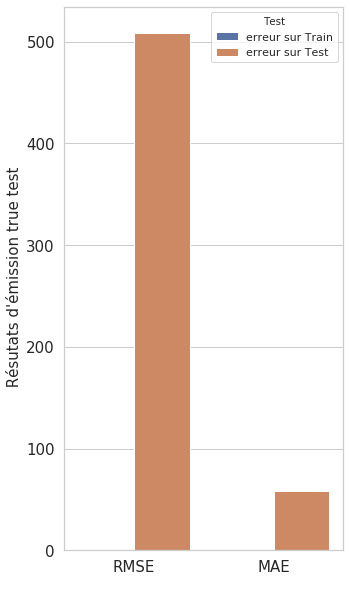

In [930]:
fig, ax = plt.subplots(1, figsize=(5, 10))

sns.set(style="whitegrid")
e = diffEMI.loc[ (diffEMI["type d'erreur"] == "RMSE") | (diffEMI["type d'erreur"] =="MAE")]
sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.set_xlabel(" ")
ax.set_ylabel(" Résutats d'émission true test", fontsize=15)



# fig = plt.figure(figsize=(5,10))
# plot = fig.add_subplot(1,1,1)
# sns.set(style="whitegrid")
# e = diffEMI.loc[ (diffEMI["type d'erreur"] == "RMSE") | (diffEMI["type d'erreur"] =="MAE")]
# ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Test", data=e)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)

Text(0.5, 0, ' ')

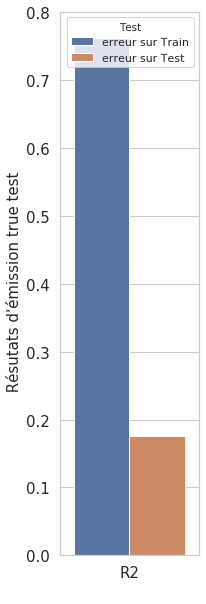

In [931]:
fig, ax = plt.subplots(1, figsize=(2.5, 10))

sns.set(style="whitegrid")
e = diffEMI.loc[diffEMI["type d'erreur"] == "R2"]
sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


ax.set_ylabel(" Résutats d'émission true test", fontsize=15)
ax.set_xlabel(" ")

In [932]:
diffEMI

Modèle type d'erreur  Résutats d'émission              Test
21  RandomForestRegressor            R2             0.762611  erreur sur Train
22  RandomForestRegressor          RMSE             0.730063  erreur sur Train
23  RandomForestRegressor           MAE             0.505717  erreur sur Train
21  RandomForestRegressor            R2             0.175545   erreur sur Test
22  RandomForestRegressor          RMSE           508.836638   erreur sur Test
23  RandomForestRegressor           MAE            58.595207   erreur sur Test

In [933]:
diffEMI.loc[diffEMI["type d'erreur"] == "R2"]

Modèle type d'erreur  Résutats d'émission              Test
21  RandomForestRegressor            R2             0.762611  erreur sur Train
21  RandomForestRegressor            R2             0.175545   erreur sur Test

### Consomation

In [949]:
ERROR = {'EMI': [], 'CONSO': []}
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

In [950]:
params = {
        'randomforestregressor__n_estimators': [100],    
        'randomforestregressor__max_depth': [40],
        'randomforestregressor__min_samples_leaf': [1],   
        'randomforestregressor__max_features': [10],   
}

# score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

#### erreur sur log CONSO

In [951]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logCONSO"]
y_pred = grid.predict(X_test_noStar)
err = r2_score(y_true, y_pred)
ERROR["CONSO"].append(err)

In [952]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["CONSO"].append(err)

In [953]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["CONSO"].append(err)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

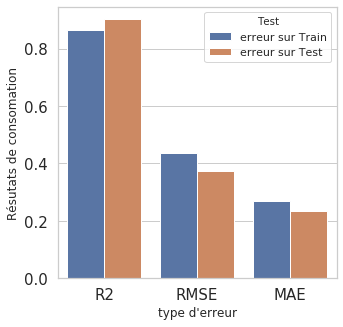

In [954]:
diffCONSO_Train = bestCONSO_noStar.copy()
diffCONSO_Train["Test"] = "erreur sur Train"

diffCONSO_True = bestCONSO_noStar.copy()
diffCONSO_True["Test"] = "erreur sur Test"
diffCONSO_True["Résutats de consomation"] = ERROR["CONSO"] 
diffCONSO = pd.concat([diffCONSO_Train, diffCONSO_True])
diffCONSO


In [ ]:


fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [955]:
diffCONSO

Modèle type d'erreur  Résutats de consomation  \
21  RandomForestRegressor            R2                 0.865769   
22  RandomForestRegressor          RMSE                 0.435564   
23  RandomForestRegressor           MAE                 0.268599   
21  RandomForestRegressor            R2                 0.901610   
22  RandomForestRegressor          RMSE                 0.372722   
23  RandomForestRegressor           MAE                 0.235638   

                Test  
21  erreur sur Train  
22  erreur sur Train  
23  erreur sur Train  
21   erreur sur Test  
22   erreur sur Test  
23   erreur sur Test

#### erreur sur CONSO

y_pred = np.exp(y_pred)   et      y_true= np.exp(y_true)  

In [956]:
ERROR = {'EMI': [], 'CONSO': []}


In [957]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logCONSO"]
y_true= np.exp(y_true)  
y_pred = grid.predict(X_test_noStar)
y_pred = np.exp(y_pred)
err = r2_score(y_true, y_pred)
ERROR["CONSO"].append(err)

In [958]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["CONSO"].append(err)

In [959]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["CONSO"].append(err)

In [960]:
diffCONSO_Train = bestCONSO_noStar.copy()
diffCONSO_Train["Test"] = "erreur sur Train"

diffCONSO_True = bestCONSO_noStar.copy()
diffCONSO_True["Test"] = "erreur sur Test"
diffCONSO_True["Résutats de consomation"] = ERROR["CONSO"] 


diffCONSO = pd.concat([diffCONSO_Train, diffCONSO_True])
diffCONSO

Modèle type d'erreur  Résutats de consomation  \
21  RandomForestRegressor            R2             8.657686e-01   
22  RandomForestRegressor          RMSE             4.355635e-01   
23  RandomForestRegressor           MAE             2.685987e-01   
21  RandomForestRegressor            R2             8.783307e-01   
22  RandomForestRegressor          RMSE             1.037684e+07   
23  RandomForestRegressor           MAE             3.299186e+06   

                Test  
21  erreur sur Train  
22  erreur sur Train  
23  erreur sur Train  
21   erreur sur Test  
22   erreur sur Test  
23   erreur sur Test

Text(0, 0.5, ' Résutats de consomation true test')

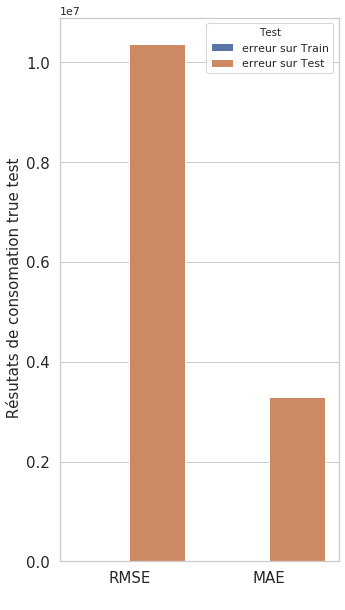

In [961]:
fig, ax = plt.subplots(1, figsize=(5, 10))

sns.set(style="whitegrid")
e = diffCONSO.loc[ (diffCONSO["type d'erreur"] == "RMSE") | (diffCONSO["type d'erreur"] =="MAE")]
sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.set_xlabel(" ")
ax.set_ylabel(" Résutats de consomation true test", fontsize=15)


In [962]:
diffCONSO.loc[ (diffCONSO["type d'erreur"] == "RMSE") |      (diffCONSO["type d'erreur"] =="MAE")]

Modèle type d'erreur  Résutats de consomation  \
22  RandomForestRegressor          RMSE             4.355635e-01   
23  RandomForestRegressor           MAE             2.685987e-01   
22  RandomForestRegressor          RMSE             1.037684e+07   
23  RandomForestRegressor           MAE             3.299186e+06   

                Test  
22  erreur sur Train  
23  erreur sur Train  
22   erreur sur Test  
23   erreur sur Test

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'higher right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


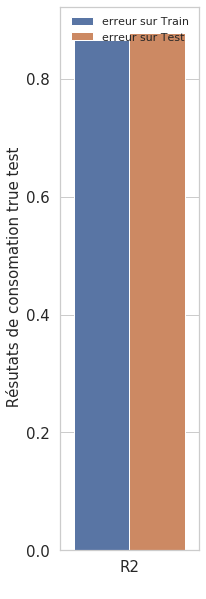

In [980]:

fig, ax = plt.subplots(1, figsize=(2.5, 10))

sns.set(style="whitegrid")
e = diffCONSO.loc[diffCONSO["type d'erreur"] == "R2"]
sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


ax.set_ylabel(" Résutats de consomation true test", fontsize=15)
ax.set_xlabel(" ")
legend = plt.legend(loc="higher right", frameon=False, shadow=True)

legend.get_frame().set_facecolor('white')
plt.show()


## ACP

### Analyse

In [448]:
from functions import *
from sklearn import decomposition

In [449]:
n_comp = 21
pca = decomposition.PCA(n_components = n_comp)

X_train_noStar_std = preprocessor.fit_transform(X_train_noStar)

pca.fit(X_train_noStar_std)


PCA(copy=True, iterated_power='auto', n_components=21, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

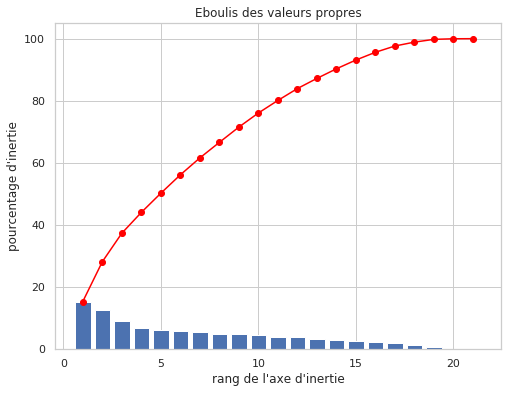

In [450]:

fig, ax = plt.subplots(1, figsize=(8, 6))

display_scree_plot(pca)


### reduction

In [451]:
from sklearn import decomposition


pca = decomposition.PCA()
model_ML = RandomForestRegressor(max_depth = 22, n_estimators=100)

model = make_pipeline(preprocessor,pca)




In [452]:
pipe = make_pipeline(model, model_ML)

pipe.steps

[('pipeline', Pipeline(memory=None,
           steps=[('columntransformer',
                   ColumnTransformer(n_jobs=None, remainder='drop',
                                     sparse_threshold=0.3,
                                     transformer_weights=None,
                                     transformers=[('pipeline-1',
                                                    Pipeline(memory=None,
                                                             steps=[('standardscaler',
                                                                     StandardScaler(copy=True,
                                                                                    with_mean=True,
                                                                                    with_std=True))],
                                                             verbose=False),
                                                    ['CouncilDistrictCode',
                                                     'Yea

In [453]:
params = {
    'pipeline__pca__n_components': [1,2,3,5,10, 21],
    'randomforestregressor__max_depth': [50],  
    'randomforestregressor__n_estimators': [100],  
}

grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring="r2", refit = True)


In [454]:
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pipeline',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('pipeline-1',
                                                                                          Pipeline(memory=None,
                                                                                                   steps=[('standardscaler',
       

In [455]:
# params = {
#     'pipeline__pca__n_components': [10, 15],
#     'randomforestregressor__max_depth': [10,20],
#     'randomforestregressor__n_estimators': [50,100,150],    
# }

Text(0, 0.5, 'précision r2')

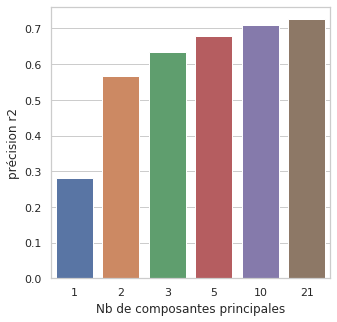

In [456]:
paramList = list(params.keys())
fig, ax = plt.subplots(1, figsize=(5, 5))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_score'][j])
    sns.barplot(t, s)
ax.set_xlabel('Nb de composantes principales')
ax.set_ylabel('précision r2')
# plt.legend(loc="higher left", title="Legend Title", frameon=False)

## descente de selection de variable

In [457]:
import re

descente_colonne = X_train_noStar.columns[0:6].to_list()

colUType = []

for col in X_train_noStar.columns : 
    if re.search("^UType", col) : 
        colUType.append(col)

colBType = []

for col in X_train_noStar.columns : 
    if re.search("^BType", col) : 
        colBType.append(col)        

        
descente_colonne.append(colUType)
descente_colonne.append(colBType)
         
        
# X_descent


### CONSO

In [495]:
model_ML = RandomForestRegressor()
model_name = re.search("(^\w*)", str(model_ML)).group(0)

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1]
}

descente_X_train_noStar = X_train_noStar.copy()

ERROR_descente = []

ERROR_Full_descente = {
    'Iter': [],
    'colonne_eliminee': [],
    "score" : [],
}

for i in range(np.shape(descente_colonne)[0] -1) : 
    # boucle de 1 à 11 variables
    print("--------------------------------------------")
    print("\n\ni", i, np.shape(descente_X_train_noStar), descente_X_train_noStar.columns)
    ERROR_bestscore = {"col" : 0 , "score" : 0.  }

    # boucle pour determiner la meilleurs variables 

    descente_temp_X_train_noStar = descente_X_train_noStar.copy()

    for col_a_eliminer in descente_colonne : 
        print("\ncol_a_eliminer", col_a_eliminer)
        coltest = col_a_eliminer
        if type(col_a_eliminer) is list: coltest = col_a_eliminer[0]
        if coltest in (descente_X_train_noStar) : 
           

            descente_temp_X_train_noStar = descente_X_train_noStar.drop(columns = col_a_eliminer)

            print("ellimination reussi")

            preprocessor = make_column_transformer((numerical_pipeline, descente_temp_X_train_noStar.columns ))

            model = make_pipeline(preprocessor,model_ML)

            grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
            grid.fit(descente_temp_X_train_noStar,Y_train_noStarCONSO)

            if (ERROR_bestscore["score"]<grid.best_score_) : 
                ERROR_bestscore["col"] =  col_a_eliminer
                ERROR_bestscore["score"] =  grid.best_score_
            
            ERROR_Full_descente['Iter'].append(i)
            if re.search("^UType", coltest) : 
                ERROR_Full_descente['colonne_eliminee'].append("UType")
            else : 
                if re.search("^BType", coltest) : ERROR_Full_descente['colonne_eliminee'].append("BType")
                else :
                     ERROR_Full_descente['colonne_eliminee'].append(coltest)
            ERROR_Full_descente['score'].append(grid.best_score_)

            
            print("\n ------- \nERROR_Full_descente : {}\n ------- \n".format(ERROR_Full_descente))
            
            
        else : 
            print("pas de colonne", col_a_eliminer, "dans descente_X_train_noStar")
    
    descente_X_train_noStar = descente_X_train_noStar.drop(columns = ERROR_bestscore["col"])
    
    print("\n drop bonne colonne reussi : ", ERROR_bestscore["col"], print(np.shape(descente_X_train_noStar)))
    ERROR_descente.append(ERROR_bestscore)
    
    print("ERROR_descente", ERROR_descente)

--------------------------------------------


i 0 (5212, 21) Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

col_a_eliminer CouncilDistrictCode
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0], 'colonne_eliminee': ['CouncilDistrictCode'], 'score': [0.8591048250412054]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt'], 'score': [0.8591048250412054, 0.8497329801859108]}
 ------- 


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode'], 'score': [0.8591048250412054, 0.8497329801859108, 0.8611704551567433, 0.8568045611804666, 0.8462790422485377, 0.6907086162805285, 0.8435481394281679, 0.8578729077965965, 0.8587813522818555, 0.8512239342231392, 0.8585853920141394, 0.8469562420420562, 0.6943314502404363, 0.8435646879789644, 0.8596404104997074, 0.8570750644198277]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt',


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark'], 'score': [0.8591048250412054, 0.8497329801859108, 0.8611704551567433, 0.8568045611804666, 0.8462790422485377, 0.6907086162805285, 0.8435481394281679, 0.8578729077965965, 0.8587813522818555, 0.8512239342231392, 0.8585853920141394, 0.8469562420420562, 0.6943314502404363, 0.8435646879789644, 0.8596404104997074, 0.8570750644198277, 0.8507274278271879, 0.856221227283289, 0.8445915989732, 0.6883250257457381, 0.828477370597211, 0.8444923738801094, 0.8550380527733882, 0.8413723587903496]}
 ------- 


col_a_eliminer logGFAB


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType'], 'score': [0.8591048250412054, 0.8497329801859108, 0.8611704551567433, 0.8568045611804666, 0.8462790422485377, 0.6907086162805285, 0.8435481394281679, 0.8578729077965965, 0.8587813522818555, 0.8512239342231392, 0.8585853920141394, 0.8469562420420562, 0.6943314502404363, 0.8435646879789644, 0.8596404104997074, 0.8570750644198277, 0.8507274278271879, 0.856221227283289, 0.8445915989732, 0.6883250257457381, 0.828477370597211, 0.


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFABuild', 'UType', 'logGFABuild'], 'score': [0.8591048250412054, 0.8497329801859108, 0.8611704551567433, 0.8568045611804666, 0.8462790422485377, 0.6907086162805285, 0.8435481394281679, 0.8578729077965965, 0.8587813522818555, 0.8512239342231392, 0.8585853920141394, 0.8469562420420562, 0.6943314502404363, 0.8435646879789644, 0.8596404104997074, 0.8570750644198277, 0.8507274278271879, 0.85622122728

In [496]:
variable = []
resultr2 = []
for errorcol in ERROR_descente : 
    varCol = errorcol['col']
    if type(varCol) is list: 
        if re.search("^UType", varCol[0]) : varCol = "Usage Type"
        if re.search("^BType", varCol[0]) : varCol = "Building Type"
        
    variable.append(varCol)
    resultr2.append(errorcol['score'])
variable    

['sqrtNbBuild',
 'Building Type',
 'CouncilDistrictCode',
 'sqrtNbFloor',
 'logGFAPark',
 'YearBuilt',
 'Usage Type']

In [497]:
d = {
    'Variable' : variable,
    "Résutats r2": resultr2
}

ERROR_Full_descente = pd.DataFrame(ERROR_Full_descente)


In [498]:
descente_Result= pd.DataFrame(data=d)

Text(0.5, 0, ' ')

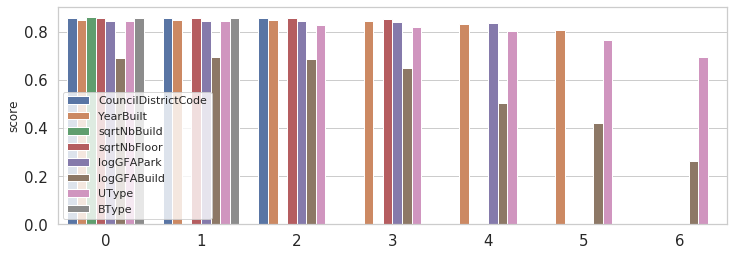

In [499]:
fig = plt.figure(figsize=(12,4))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ERROR_Full_descente
ax = sns.barplot(x="Iter", y="score",hue="colonne_eliminee", data=e)
ax.legend(loc='lower left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


plt.xlabel(" " , fontsize=18)

In [507]:
params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],      
}
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

model = make_pipeline(preprocessor,model_ML)

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarCONSO)
maxScore = grid.best_score_
maxScore

0.865900752597385

In [501]:
ScoreCumule = np.array([np.zeros(8)]*7, np.float64)

In [502]:
d = ERROR_Full_descente["colonne_eliminee"].unique()
listcolumns = pd.DataFrame(d, columns=["var"])
print(listcolumns.loc[listcolumns["var"] == "BType"].index.to_list()[0])

7


In [503]:

for k in range(7) :

    for index, col in enumerate(listcolumns["var"].to_list()):

        
        score = ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==k].loc[ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==k]["colonne_eliminee"] == col]["score"]
        
        
        if np.shape(score)[0] == 1 : 
            ScoreCumule[k][index] = maxScore-score
        else : 
            ScoreCumule[k][index] = ScoreCumule[k-1][index]
 

In [504]:
tab = np.concatenate((ERROR_Full_descente["colonne_eliminee"].unique(), 
                      ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab= np.concatenate((tab, tab), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)


In [505]:

res = np.reshape(ScoreCumule, (1,np.product(ScoreCumule.shape)))[0]

d = {
    'Variable' : tab,
    "Score cumulé": res,
    "Iter": [0]*8+[1]*8+[2]*8+[3]*8+[4]*8+[5]*8+[6]*8
}

ScoreCumuleResult =  pd.DataFrame(d)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

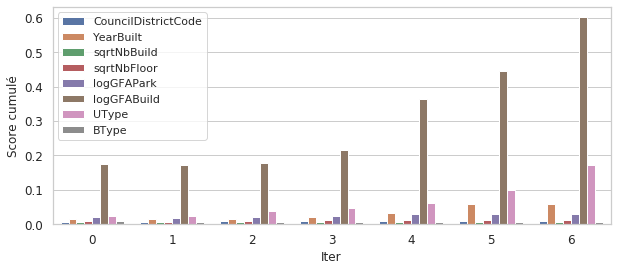

In [506]:
fig = plt.figure(figsize=(10,4))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ScoreCumuleResult
ax = sns.barplot(x="Iter", y="Score cumulé",hue="Variable", data=e)
ax.legend(loc='upper left')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

In [470]:

res = np.reshape(ScoreCumule, (1,np.product(ScoreCumule.shape)))[0]

d = {
    'Variable' : ERROR_Full_descente["colonne_eliminee"].unique(),
    "Score moyenné": np.mean(ScoreCumule, axis=0),
    "Moyenne sur les iterations": [" "]*8
}

ScoreCumuleResult =  pd.DataFrame(d)

In [471]:
ScoreCumuleOrd = [np.mean(ScoreCumule, axis=0)[2],
                 np.mean(ScoreCumule, axis=0)[7],
                 np.mean(ScoreCumule, axis=0)[3],
                 np.mean(ScoreCumule, axis=0)[0],
                 np.mean(ScoreCumule, axis=0)[4],
                 np.mean(ScoreCumule, axis=0)[1],
                 np.mean(ScoreCumule, axis=0)[6],
                 np.mean(ScoreCumule, axis=0)[5]                 
                 ]

xOrd = ["sqrtNbBuild",
        "BType",
        "sqrtNbFloor",
        "CouncilDistr",
        "logGFAPark",
        "YearBuilt",
        "UType",
        "logGFABuild" ] 
                  
d = {
    'Variable' : xOrd,
    "Score moyenné": ScoreCumuleOrd
}

ScoreCumuleResultOrd =  pd.DataFrame(d)

No handles with labels found to put in legend.


Text(0, 0.5, ' ')

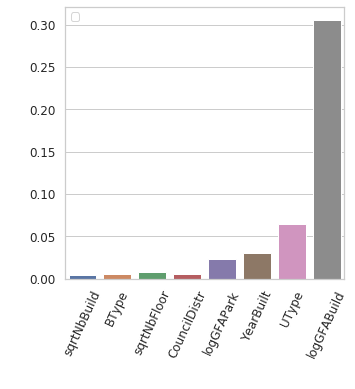

In [472]:
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ScoreCumuleResultOrd
ax = sns.barplot(x="Variable", y="Score moyenné", data=e)
ax.legend(loc='upper left')

plt.xticks(rotation=65)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)



plt.xlabel(" " , fontsize=18)
plt.ylabel(" " , fontsize=18)

### EMI

In [473]:
model_ML = RandomForestRegressor()
model_name = re.search("(^\w*)", str(model_ML)).group(0)

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1] 
}

descente_X_train_noStar = X_train_noStar.copy()

ERROR_descente = []

ERROR_Full_descente = {
    'Iter': [],
    'colonne_eliminee': [],
    "score" : [],
}

for i in range(np.shape(descente_colonne)[0] -1) : 
    # boucle de 1 à 11 variables
    print("--------------------------------------------")
    print("\n\ni", i, np.shape(descente_X_train_noStar), descente_X_train_noStar.columns)
    ERROR_bestscore = {"col" : 0 , "score" : 0.  }

    # boucle pour determiner la meilleurs variables 

    descente_temp_X_train_noStar = descente_X_train_noStar.copy()

    for col_a_eliminer in descente_colonne : 
        print("\ncol_a_eliminer", col_a_eliminer)
        coltest = col_a_eliminer
        if type(col_a_eliminer) is list: coltest = col_a_eliminer[0]
        if coltest in (descente_X_train_noStar) : 
           

            descente_temp_X_train_noStar = descente_X_train_noStar.drop(columns = col_a_eliminer)

            print("ellimination reussi")

            preprocessor = make_column_transformer((numerical_pipeline, descente_temp_X_train_noStar.columns ))

            model = make_pipeline(preprocessor,model_ML)

            grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
            grid.fit(descente_temp_X_train_noStar,Y_train_noStarEMI)

            if (ERROR_bestscore["score"]<grid.best_score_) : 
                ERROR_bestscore["col"] =  col_a_eliminer
                ERROR_bestscore["score"] =  grid.best_score_
            
            ERROR_Full_descente['Iter'].append(i)
            if re.search("^UType", coltest) : 
                ERROR_Full_descente['colonne_eliminee'].append("UType")
            else : 
                if re.search("^BType", coltest) : ERROR_Full_descente['colonne_eliminee'].append("BType")
                else :
                     ERROR_Full_descente['colonne_eliminee'].append(coltest)
            ERROR_Full_descente['score'].append(grid.best_score_)

            
            print("\n ------- \nERROR_Full_descente : {}\n ------- \n".format(ERROR_Full_descente))
            
            
        else : 
            print("pas de colonne", col_a_eliminer, "dans descente_X_train_noStar")
    
    descente_X_train_noStar = descente_X_train_noStar.drop(columns = ERROR_bestscore["col"])
    
    print("\n drop bonne colonne reussi : ", ERROR_bestscore["col"], print(np.shape(descente_X_train_noStar)))
    ERROR_descente.append(ERROR_bestscore)
    
    print("ERROR_descente", ERROR_descente)

--------------------------------------------


i 0 (5212, 21) Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

col_a_eliminer CouncilDistrictCode
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0], 'colonne_eliminee': ['CouncilDistrictCode'], 'score': [0.750496869467588]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt'], 'score': [0.750496869467588, 0.6972959291561015]}
 ------- 




 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode'], 'score': [0.750496869467588, 0.6972959291561015, 0.7582851201195103, 0.7547902173654364, 0.7556213371151498, 0.620438356893325, 0.7293197109459053, 0.7551380789108755, 0.7519350046501693, 0.7018067811024827, 0.7587681350750033, 0.7602004381513556, 0.6240016506106996, 0.7308729605883637, 0.7582326096503087, 0.7488416434470182]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', '


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'logGFABuild'], 'score': [0.750496869467588, 0.6972959291561015, 0.7582851201195103, 0.7547902173654364, 0.7556213371151498, 0.620438356893325, 0.7293197109459053, 0.7551380789108755, 0.7519350046501693, 0.7018067811024827, 0.7587681350750033, 0.7602004381513556, 0.6240016506106996, 0.7308729605883637, 0.7582326096503087, 0.7488416434470182, 0.6952703174601907, 0.7551032890227386, 0.6211314870396837, 0.72829251236101, 0.7531477707554284, 0.7465371365965653, 0.6870730523930042, 0.5423525945514477]}
 ------- 


col_a_eliminer ['


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'logGFABuild', 'UType'], 'score': [0.750496869467588, 0.6972959291561015, 0.7582851201195103, 0.7547902173654364, 0.7556213371151498, 0.620438356893325, 0.7293197109459053, 0.7551380789108755, 0.7519350046501693, 0.7018067811024827, 0.7587681350750033, 0.7602004381513556, 0.6240016506106996, 0.7308729605883637, 0.7582326096503087, 0.7488416434470182, 0.6952703174601907, 0.7551032890227386, 0.6211314870396837, 0.72829251236101, 0.753147770755


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'logGFABuild', 'UType', 'YearBuilt', 'logGFABuild', 'UType', 'YearBuilt'], 'score': [0.750496869467588, 0.6972959291561015, 0.7582851201195103, 0.7547902173654364, 0.7556213371151498, 0.620438356893325, 0.7293197109459053, 0.7551380789108755, 0.7519350046501693, 0.7018067811024827, 0.7587681350750033, 0.7602004381513556, 0.6240016506106996, 0.7308729605883637, 0.7582326096503087, 0.7488416434470182, 0.6952703174601907, 0.75510328

In [474]:
variable = []
resultr2 = []
for errorcol in ERROR_descente : 
    varCol = errorcol['col']
    if type(varCol) is list: 
        if re.search("^UType", varCol[0]) : varCol = "Usage Type"
        if re.search("^BType", varCol[0]) : varCol = "Building Type"
        
    variable.append(varCol)
    resultr2.append(errorcol['score'])
variable    

['sqrtNbBuild',
 'logGFAPark',
 'sqrtNbFloor',
 'Building Type',
 'CouncilDistrictCode',
 'Usage Type',
 'YearBuilt']

In [475]:
d = {
    'Variable' : variable,
    "Résutats r2": resultr2
}

ERROR_Full_descente = pd.DataFrame(ERROR_Full_descente)


In [476]:
descente_Result= pd.DataFrame(data=d)

Text(0.5, 0, ' ')

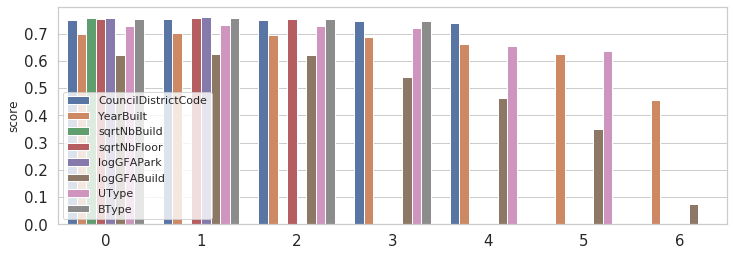

In [477]:
fig = plt.figure(figsize=(12,4))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ERROR_Full_descente
ax = sns.barplot(x="Iter", y="score",hue="colonne_eliminee", data=e)
ax.legend(loc='lower left')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


plt.xlabel(" " , fontsize=18)

In [478]:
params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],      
}
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

model = make_pipeline(preprocessor,model_ML)

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarEMI)
maxScore = grid.best_score_


In [479]:
ScoreCumule = np.array([np.zeros(8)]*7, np.float64)

In [480]:
d = ERROR_Full_descente["colonne_eliminee"].unique()
listcolumns = pd.DataFrame(d, columns=["var"])
print(listcolumns.loc[listcolumns["var"] == "BType"].index.to_list()[0])

7


In [481]:

for k in range(7) :

    for index, col in enumerate(listcolumns["var"].to_list()):

        
        score = ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==k].loc[ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==k]["colonne_eliminee"] == col]["score"]
        
        
        if np.shape(score)[0] == 1 : 
            ScoreCumule[k][index] = maxScore-score
        else : 
            ScoreCumule[k][index] = ScoreCumule[k-1][index]
 

In [482]:
tab = np.concatenate((ERROR_Full_descente["colonne_eliminee"].unique(), 
                      ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab= np.concatenate((tab, tab), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)
tab = np.concatenate((tab, ERROR_Full_descente["colonne_eliminee"].unique()), axis=0)


In [483]:

res = np.reshape(ScoreCumule, (1,np.product(ScoreCumule.shape)))[0]

d = {
    'Variable' : tab,
    "Score cumulé": res,
    "Iter": [0]*8+[1]*8+[2]*8+[3]*8+[4]*8+[5]*8+[6]*8
}

ScoreCumuleResult =  pd.DataFrame(d)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

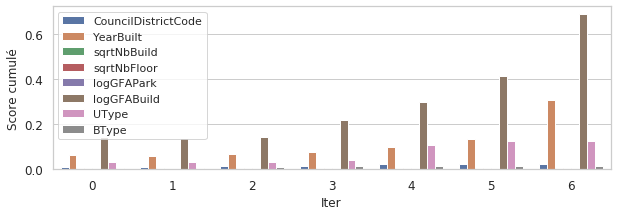

In [484]:
fig = plt.figure(figsize=(10,3))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ScoreCumuleResult
ax = sns.barplot(x="Iter", y="Score cumulé",hue="Variable", data=e)
ax.legend(loc='upper left')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

In [485]:

res = np.reshape(ScoreCumule, (1,np.product(ScoreCumule.shape)))[0]

d = {
    'Variable' : ERROR_Full_descente["colonne_eliminee"].unique(),
    "Score moyenné": np.mean(ScoreCumule, axis=0),
    "Moyenne sur les iterations": [" "]*8
}

ScoreCumuleResult =  pd.DataFrame(d)

In [486]:
ScoreCumuleOrd = [np.mean(ScoreCumule, axis=0)[2],
                 np.mean(ScoreCumule, axis=0)[7],
                 np.mean(ScoreCumule, axis=0)[3],
                 np.mean(ScoreCumule, axis=0)[0],
                 np.mean(ScoreCumule, axis=0)[4],
                 np.mean(ScoreCumule, axis=0)[1],
                 np.mean(ScoreCumule, axis=0)[6],
                 np.mean(ScoreCumule, axis=0)[5]                 
                 ]

xOrd = ["sqrtNbBuild",
        "BType",
        "sqrtNbFloor",
        "CouncilDistr",
        "logGFAPark",
        "YearBuilt",
        "UType",
        "logGFABuild" ] 
                  
d = {
    'Variable' : xOrd,
    "Score moyenné": ScoreCumuleOrd
}

ScoreCumuleResultOrd =  pd.DataFrame(d)

No handles with labels found to put in legend.


Text(0, 0.5, ' ')

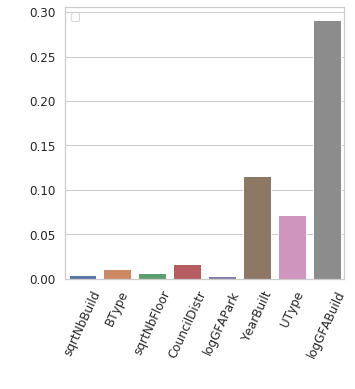

In [487]:
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ScoreCumuleResultOrd
ax = sns.barplot(x="Variable", y="Score moyenné", data=e)
ax.legend(loc='upper left')

plt.xticks(rotation=65)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)



plt.xlabel(" " , fontsize=18)
plt.ylabel(" " , fontsize=18)

## Verif R2 score avec feature importance des foret

In [488]:
descente_colonne

['CouncilDistrictCode',
 'YearBuilt',
 'sqrtNbBuild',
 'sqrtNbFloor',
 'logGFAPark',
 'logGFABuild',
 ['UType_Hotel',
  'UType_K-12 School',
  'UType_Multifamily Housing',
  'UType_Non-Refrigerated Warehouse',
  'UType_Office',
  'UType_Other',
  'UType_Parking',
  'UType_Restaurant',
  'UType_Retail Store'],
 ['BType_Multifamily HR (10+)',
  'BType_Multifamily LR (1-4)',
  'BType_Multifamily MR (5-9)',
  'BType_NonResidential',
  'BType_Nonresidential COS',
  'BType_SPS-District K-12']]

In [489]:
col_a_eliminer = [descente_colonne[0], descente_colonne[1] , descente_colonne[2],descente_colonne[3]]+descente_colonne[6] + descente_colonne[7]

col_a_eliminer

['CouncilDistrictCode',
 'YearBuilt',
 'sqrtNbBuild',
 'sqrtNbFloor',
 'UType_Hotel',
 'UType_K-12 School',
 'UType_Multifamily Housing',
 'UType_Non-Refrigerated Warehouse',
 'UType_Office',
 'UType_Other',
 'UType_Parking',
 'UType_Restaurant',
 'UType_Retail Store',
 'BType_Multifamily HR (10+)',
 'BType_Multifamily LR (1-4)',
 'BType_Multifamily MR (5-9)',
 'BType_NonResidential',
 'BType_Nonresidential COS',
 'BType_SPS-District K-12']

In [490]:
descente_temp_X_train_noStar = X_train_noStar.drop(col_a_eliminer, axis=1)

In [491]:
descente_temp_X_train_noStar

logGFAPark  logGFABuild
0       9.768298    10.511621
1       0.000000    10.735527
2       0.000000    11.591995
3       0.000000    10.093943
4       0.000000    10.518727
...          ...          ...
5207    0.000000     9.980449
5208    0.000000    11.218675
5209    8.723719    10.265871
5210    9.331673    10.912540
5211    0.000000    13.492751

[5212 rows x 2 columns]

In [492]:
Y_train_noStarCONSO

0       15.535368
1       15.627378
2       16.154258
3       14.785290
4       14.893226
          ...    
5207    14.641053
5208    16.247150
5209    14.299179
5210    15.874593
5211    18.304122
Name: logCONSO, Length: 5212, dtype: float64

In [493]:
model_ML = RandomForestRegressor()
model_name = re.search("(^\w*)", str(model_ML)).group(0)

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1] 
}

preprocessor = make_column_transformer((numerical_pipeline, descente_temp_X_train_noStar.columns ))

model = make_pipeline(preprocessor,model_ML)

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(descente_temp_X_train_noStar,Y_train_noStarCONSO)

print("best score CONSO forest selection", grid.best_score_)

best score CONSO forest selection 0.7492174878570725
